In [1]:
import json
import numpy as np
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import product
import math
from utils import *
from eval.metrics import compute_pareto_frontier


def parse_values(line):
    """Parse the line containing private values"""
    # Format: "Your private values are 16 for item 1, 46 for item 2, 100 for item 3, 23 for item 4, 47 for item 5."
    values = []
    parts = line.split("are ")[1].split(", ")
    for part in parts:
        value = int(part.split(" for item")[0])
        values.append(value)
    return values

def parse_outside_offer(line):
    """Parse the line containing outside offer"""
    # Format: "Your outside offer value is 145. Your objective..."
    return int(line.split("value is ")[1].split(".")[0])

def calculate_value(items_received, values):
    """Calculate value of items received given the player's values"""
    return sum(items_received[i] * values[i] for i in range(len(values)))

def compute_max_nash_welfare(item_counts, p1_valuations, p2_valuations):
    if len(item_counts) != len(p1_valuations) or len(item_counts) != len(p2_valuations):
        raise ValueError("item_counts, p1_valuations, p2_valuations must have the same length.")

    K = len(item_counts)
    max_nash = -1.0
    best_alloc = None
    outside_offer_player1 = np.random.randint(1, np.dot(item_counts, p1_valuations))
    outside_offer_player2 = np.random.randint(1, np.dot(item_counts, p2_valuations))
    ranges = [range(n_i + 1) for n_i in item_counts] 
    for allocation in product(*ranges):
        p1_util = 0.0
        p2_util = 0.0
        for i in range(K):
            x_i = allocation[i]
            n_i = item_counts[i]
            p1_util += x_i * p1_valuations[i]
            p2_util += (n_i - x_i) * p2_valuations[i]

        w = math.sqrt(max(p1_util, 0) * max(p2_util, 0))

        if w > max_nash:
            max_nash = w
            best_alloc = allocation

        #outside offer check
        if max_nash < np.sqrt(outside_offer_player1 * outside_offer_player2):
            max_nash = np.sqrt(outside_offer_player1 * outside_offer_player2)
            best_alloc = [0, 0, 0, 0, 0]

    return max_nash, list(best_alloc)




        
def analyze_single_game(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    results = []
    for game in data['all_game_data']:
        agent1 = game['agent1']
        agent2 = game['agent2']
        
        # Remove Agent1_ and Agent2_ prefixes if they exist
        if agent1.startswith("Agent1_"):
            agent1 = agent1[7:]
        if agent2.startswith("Agent2_"):
            agent2 = agent2[7:]
        
        # Track the final state
        final_action = None
        final_round_index = len(game['round_data']) - 1
        # Convert to actual round number (2 turns = 1 round)
        final_round_number = (final_round_index // 2) + 1
        final_offer = None
        p1_outside_offer = None
        p2_outside_offer = None
        p1_values = None
        p2_values = None
        num_items = None
        full_items = None

        # First, gather all the necessary data from all rounds
        for round_idx, round_data in enumerate(game['round_data']):
            prompt = round_data['prompt']
            
            # Check if this is the final turn
            if round_idx == final_round_index:
                final_action = round_data['action']
            
            if "You are Player 1" in prompt:
                # Extract Player 1's values and outside offer
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p1_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p1_outside_offer = parse_outside_offer(line)
                    elif "There are" in line and "units of item" in line:
                        if num_items is None:
                            # Extract numbers before "units of item"
                            nums = []
                            parts = line.split("There are ")[1].split(", ")
                            for part in parts:
                                num = int(part.split(" units")[0])
                                nums.append(num)
                            num_items = nums
            elif "You are Player 2" in prompt:
                # Extract Player 2's values and outside offer
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p2_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p2_outside_offer = parse_outside_offer(line)
            
            # Track the current offer
            if "Current offer on the table" in prompt:
                offer_line = prompt.split("Current offer on the table")[1].split("\n")[0]
                if "None" not in offer_line and "[" in offer_line:
                    final_offer = eval(offer_line[offer_line.find("["):offer_line.find("]")+1])
        
        # Calculate final values
        p1_final_value = None
        p2_final_value = None
        
        # Calculate discount factor based on the round number (0.9^(round-1))
        discount_factor = 0.9 ** (final_round_number - 1)
        # discount_factor = 1
        p1_items = None
        p2_items = None
        if final_action == "WALK" or final_action == "INVALID WALK":
            # Check if this is player 1's first action
            if final_round_number == 1 and "You are Player 1" in game['round_data'][final_round_index]['prompt']:
                # Don't count the game if player 1 walks on their first action
                # p1_final_value = p1_outside_offer * discount_factor
                p1_final_value = None
                p2_final_value = None
            else:
                p1_final_value = p1_outside_offer * discount_factor
                # if p2_outside_offer is None:
                #     # Generate random values between 1 and 101 for each item
                #     random_values = [random.randint(1, 101) for _ in range(len(num_items))]
                #     # Calculate total value if player had all items
                #     total_possible_value = sum(random_values[i] * num_items[i] for i in range(len(num_items)))
                #     # Generate random outside offer between 1 and total value
                #     p2_outside_offer = random.randint(1, total_possible_value)
                p2_final_value = p2_outside_offer * discount_factor
        elif final_action == "ACCEPT":
            # Determine which player accepted the offer
            accepting_player = None
            for round_idx, round_data in enumerate(game['round_data']):
                if round_idx == final_round_index and round_data['action'] == "ACCEPT":
                    accepting_player = 1 if "You are Player 1" in round_data['prompt'] else 2
            
            if accepting_player == 2:
                # Player 2 accepted the offer
                # The offer represents what Player 2 receives
                p2_items = final_offer
                p1_items = [num_items[i] - final_offer[i] for i in range(len(final_offer))]
            else:
                # Player 1 accepted the offer
                # The offer represents what Player 1 receives
                p1_items = final_offer
                p2_items = [num_items[i] - final_offer[i] for i in range(len(final_offer))]
            
            p1_final_value = calculate_value(p1_items, p1_values) * discount_factor
            p2_final_value = calculate_value(p2_items, p2_values) * discount_factor
        try:
            circle_data = data['all_game_data'][0]['circle']
            if isinstance(circle_data, int):
                p1_circle = circle_data
                p2_circle = circle_data
            else:
                p1_circle = circle_data[0]
                p2_circle = circle_data[1]
        except (KeyError, TypeError, IndexError):
            # Handle missing or malformed data
            p1_circle = None
            p2_circle = None
        
        # Add circle values to agent names if available
        agent1_with_circle = f"{agent1}_circle_{p1_circle}" if p1_circle is not None else agent1
        agent2_with_circle = f"{agent2}_circle_{p2_circle}" if p2_circle is not None else agent2
      
        
        results.append({
            'agent1': agent1_with_circle,
            'agent2': agent2_with_circle,
            'final_action': final_action,
            'final_round': final_round_number,
            'discount_factor': discount_factor,
            'agent1_value': p1_final_value, #todo normalize
            'agent2_value': p2_final_value, #todo normalize
            'p1_values': p1_values,
            'p2_values': p2_values,
            'p1_items': p1_items,
            'p2_items': p2_items,
            'full_items': num_items,
            'num_items': len(p1_values),
            'p1_outside_offer': p1_outside_offer,
            'p1_outside_offer': p2_outside_offer

        })
    
    return results

# # Example usage:
file_path = "crossplay/game_matrix_1/4o_sonnet_3.7_circle_4_vs_circle_6/all_game_data_3_1_2025_20_openai_4o_vs_anthropic_3.7_sonnet_circle_p1_4_circle_p2_6.json"
results = analyze_single_game(file_path)

# Calculate average utility for each agent
agent1_values = [game['agent1_value'] for game in results if game['agent1_value'] is not None]
agent2_values = [game['agent2_value'] for game in results if game['agent2_value'] is not None]

agent1_avg = np.mean(agent1_values) if agent1_values else "N/A"
agent2_avg = np.mean(agent2_values) if agent2_values else "N/A"

# Print detailed information for each game
# print("Game Details:")
# for i, game in enumerate(results):
#     print(f"\nGame {i+1} between {game['agent1']} and {game['agent2']}")
#     print(f"Final action: {game['final_action']}")
#     print(f"Final round: {game['final_round']}")
#     print(f"Discount factor: {game['discount_factor']:.4f}")
#     print(f"Final values: Agent1: {game['agent1_value']:.2f}, Agent2: {game['agent2_value']:.2f}")

print("\nAverage Utilities:")
print(f"Agent1 ({results[0]['agent1']}): {agent1_avg}")
print(f"Agent2 ({results[0]['agent2']}): {agent2_avg}")

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-y4tk_4wl because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.



Average Utilities:
Agent1 (openai_4o_circle_4): 532.54
Agent2 (anthropic_3.7_sonnet_circle_6): 700.0836842105264


In [2]:
def create_matrix_heatmap_with_marginals(matrix, title="Matrix Heatmap", cmap="coolwarm", 
                                         fmt=".2f", figsize=(14, 12), 
                                         vmin=None, vmax=None, center=None,
                                         annot=True, normalize_marginals=False):
    """
    Create a heatmap visualization of a matrix with row and column marginals.
    
    Parameters:
    - matrix: pandas DataFrame containing the matrix data
    - title: title for the plot
    - cmap: colormap to use
    - fmt: format string for annotations
    - figsize: figure size (width, height)
    - vmin, vmax, center: color scale parameters
    - annot: whether to annotate cells
    - normalize_marginals: whether to normalize marginals (mean=1)
    
    Returns:
    - fig: the matplotlib figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    
    # Convert matrix to numeric, replacing non-numeric values with NaN
    numeric_matrix = matrix.apply(pd.to_numeric, errors='coerce')
    
    # Create mask for missing values
    mask = np.isnan(numeric_matrix)
    
    # Print verification of means calculation for debugging
    print(f"Calculating means for {title}:")
    print("Example row (openai_4o_circle_4 if available):")
    if 'openai_4o_circle_4' in numeric_matrix.index:
        row_vals = numeric_matrix.loc['openai_4o_circle_4'].dropna()
        print(f"Values: {row_vals.values}")
        print(f"Mean: {row_vals.mean()}")
    
    # Calculate row and column means (ignoring NaN values)
    row_means = numeric_matrix.mean(axis=1, skipna=True)
    col_means = numeric_matrix.mean(axis=0, skipna=True)
    
    # Normalize if requested
    if normalize_marginals:
        row_mean_value = row_means.mean()
        col_mean_value = col_means.mean()
        if not np.isnan(row_mean_value) and row_mean_value != 0:
            row_means = row_means / row_mean_value
        if not np.isnan(col_mean_value) and col_mean_value != 0:
            col_means = col_means / col_mean_value
    
    # Create a figure with gridspec for layout
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(7, 6)  # Increased to 7 rows to accommodate column means at bottom
    
    # Main heatmap (central 4x4 grid)
    ax_heatmap = fig.add_subplot(gs[1:5, 0:4])
    
    # Row marginal (right side)
    ax_row = fig.add_subplot(gs[1:5, 4:6])
    
    # Column marginal (bottom)
    ax_col = fig.add_subplot(gs[5:6, 0:4])  # Moved to bottom
    
    # Title area
    ax_title = fig.add_subplot(gs[0:1, 0:6])  # Expanded to full width
    ax_title.axis('off')
    
    # Colorbar area
    ax_cbar = fig.add_subplot(gs[6:7, :])
    ax_cbar.axis('off')
    
    # Draw the heatmap with mask for NaN values
    hm = sns.heatmap(numeric_matrix, ax=ax_heatmap, cmap=cmap, annot=annot, fmt=fmt,
                cbar=False, vmin=vmin, vmax=vmax, center=center,
                linewidths=0.5, mask=mask)
    
    # Move x-axis labels to top
    ax_heatmap.xaxis.tick_top()
    
    # Make column labels bold and match size of row labels
    ax_heatmap.set_xticklabels(
        numeric_matrix.columns, 
        rotation=80, 
        ha='center', 
        rotation_mode='anchor', 
        fontweight='bold',
    )
    
    ax_heatmap.tick_params(axis='x', pad=90)  # Changed from 15 to 25 to move labels higher

    
    # Make row labels bold
    ax_heatmap.set_yticklabels(
        ax_heatmap.get_yticklabels(),
        fontweight='bold'
    )
    
    # Row marginal (horizontal bars)
    if not row_means.isna().all():  # Check if all values are NaN
        valid_row_means = row_means.dropna()
        if len(valid_row_means) > 0 and valid_row_means.max() > valid_row_means.min():
            color_norm = (valid_row_means - valid_row_means.min()) / (valid_row_means.max() - valid_row_means.min())
            colors = plt.cm.get_cmap(cmap)(color_norm)
        else:
            colors = plt.cm.get_cmap(cmap)(0.5 * np.ones_like(valid_row_means))
        
        y_pos = np.arange(len(row_means)) + 0.5  # Center on cells
        ax_row.barh(y_pos, row_means, color=colors, edgecolor='k', linewidth=0.5, height=0.8)
        
        # Add text labels with the actual values
        for i, value in enumerate(row_means):
            if not np.isnan(value):
                ax_row.text(value + (row_means.max() * 0.02), i + 0.5, f"{value:.2f}", 
                         va='center', fontsize=9)
    
    ax_row.set_yticks([])
    ax_row.set_xlabel('Row Mean')
    ax_row.spines['top'].set_visible(False)
    ax_row.spines['right'].set_visible(False)
    ax_row.spines['left'].set_visible(False)
    ax_row.set_ylim(ax_heatmap.get_ylim())  # Match heatmap y-limits
    
    # Column marginal (horizontal bars at bottom)
    if not col_means.isna().all():  # Check if all values are NaN
        valid_col_means = col_means.dropna()
        if len(valid_col_means) > 0 and valid_col_means.max() > valid_col_means.min():
            color_norm = (valid_col_means - valid_col_means.min()) / (valid_col_means.max() - valid_col_means.min())
            colors = plt.cm.get_cmap(cmap)(color_norm)
        else:
            colors = plt.cm.get_cmap(cmap)(0.5 * np.ones_like(valid_col_means))
        
        x_pos = np.arange(len(col_means)) + 0.5  # Center on cells
        ax_col.bar(x_pos, col_means, color=colors, edgecolor='k', linewidth=0.5, width=0.8)
        
        # Add text labels with the actual values
        for i, value in enumerate(col_means):
            if not np.isnan(value):
                ax_col.text(i + 0.5, value + (col_means.max() * 0.02), f"{value:.2f}", 
                         ha='center', fontsize=9, rotation=0)
    
    ax_col.set_xticks([])
    ax_col.set_ylabel('Column Mean')
    ax_col.spines['top'].set_visible(False)
    ax_col.spines['right'].set_visible(False)
    ax_col.spines['bottom'].set_visible(False)
    ax_col.set_xlim(ax_heatmap.get_xlim())  # Match heatmap x-limits
    
    # Add a colorbar at the bottom
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjusted position
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    
    # Set colorbar limits
    vmin_actual = vmin if vmin is not None else numeric_matrix.min().min()
    vmax_actual = vmax if vmax is not None else numeric_matrix.max().max()
    
    if center is not None:
        max_abs = max(abs(vmax_actual), abs(vmin_actual))
        sm.set_clim(-max_abs, max_abs)
    else:
        sm.set_clim(vmin_actual, vmax_actual)
        
    plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    
    # Add title - centered and bolded
    ax_title.text(0.95, 0.5, title, 
              horizontalalignment='right',
              verticalalignment='center', 
              fontsize=16, 
              fontweight='bold',
              transform=ax_title.transAxes)
    
    plt.tight_layout()
    return fig


## Global Max Values for Comparison

In [3]:
global_max_nash_welfare = []
for i in range(1000):
    items = np.random.poisson(4, 5)

    player_values1 = np.random.randint(1, 101, 5) 
    player_values2 = np.random.randint(1, 101, 5)
  
    max_nash, _ = compute_max_nash_welfare(items, player_values1, player_values2)
    global_max_nash_welfare.append(max_nash)

global_max_nash_welfare = np.mean(global_max_nash_welfare)

global_stadard_max = []
for i in range(1000):
    items = np.random.poisson(4, 5)

    player_values = np.random.randint(1, 101, 5) 
    
    global_stadard_max.append(np.dot(items, player_values))

global_stadard_max = np.mean(global_max_nash_welfare)


In [4]:
all_results = []
crossplay_dir = "crossplay/game_matrix_1"
agent_performance = defaultdict(lambda: defaultdict(list))
agent_final_rounds = defaultdict(list)  
agent_game_counts = defaultdict(lambda: defaultdict(int)) 

model_mapping = {
    'openai_4o_circle_4': 'openai_4o_2024-08-06_circle_4',
    'openai_4o_circle_5': 'openai_4o_2024-08-06_circle_5',
    'openai_4o_circle_6': 'openai_4o_2024-08-06_circle_6',
    
    'anthropic_3.7_sonnet_circle_5': 'anthropic_3.7_sonnet_2025-02-19_circle_5',
    'anthropic_3.7_sonnet_circle_6': 'anthropic_3.7_sonnet_2025-02-19_circle_6',
    
    'openai_o3_mini_circle_0': 'openai_o3_mini_2025-01-31_circle_0',
}

def get_canonical_name(agent_name):
    return model_mapping.get(agent_name, agent_name)

all_results = []
crossplay_dir = "crossplay/game_matrix_1"
agent_performance = defaultdict(lambda: defaultdict(list))
agent_final_rounds = defaultdict(list) 
agent_game_counts = defaultdict(lambda: defaultdict(int))  

for root, dirs, files in os.walk(crossplay_dir):
    for file in files:
        if file.endswith('.json'):
            file_path = os.path.join(root, file)
            try:
                game_results = analyze_single_game(file_path)
                
                if any('openai_4o_circle_2' in result['agent1'] or 'openai_4o_circle_2' in result['agent2'] 
                       for result in game_results):
                    print(f"Skipping {file_path} - contains openai_4o_circle_2")
                    continue
                
                for result in game_results:
                    result['agent1'] = get_canonical_name(result['agent1'])
                    result['agent2'] = get_canonical_name(result['agent2'])
                
                all_results.extend(game_results)
                
                for result in game_results:
                    agent1 = result['agent1'] 
                    agent2 = result['agent2']
                    
                    if result['agent1_value'] is not None:
                        agent_performance[agent1][agent2].append(result['agent1_value'])
                        agent_game_counts[agent1][agent2] += 1  
                    
                    if result['agent2_value'] is not None:
                        agent_performance[agent2][agent1].append(result['agent2_value'])
                        agent_game_counts[agent2][agent1] += 1  
                    
                    # Track final rounds for each agent
                    if result['final_round'] is not None:
                        agent_final_rounds[agent1].append(result['final_round'])
                        agent_final_rounds[agent2].append(result['final_round'])
                
                agent1_values = [r['agent1_value'] for r in game_results if r['agent1_value'] is not None]
                agent2_values = [r['agent2_value'] for r in game_results if r['agent2_value'] is not None]
                
                agent1_avg = np.mean(agent1_values) if agent1_values else "N/A"
                agent2_avg = np.mean(agent2_values) if agent2_values else "N/A"
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

df = pd.DataFrame(all_results)
print(df.columns)

agent_vs_opponent_performance = {}

for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            key = f"{agent}_vs_{opponent}"
            agent_vs_opponent_performance[key] = np.mean(values)


overall_agent_performance = {}
for agent, opponents in agent_performance.items():
    all_values = []
    for values in opponents.values():
        all_values.extend(values)
    if all_values:
        overall_agent_performance[agent] = np.mean(all_values)

average_final_rounds = {}
for agent, rounds in agent_final_rounds.items():
    if rounds:
        average_final_rounds[agent] = np.mean(rounds)

print(f"\nTotal games analyzed: {len(all_results)}")
print(f"Unique agent types: {len(overall_agent_performance)}")
print(f"Unique matchups: {len(agent_vs_opponent_performance)}")

print("\nAverage Final Rounds by Agent:")
for agent, avg_round in sorted(average_final_rounds.items()):
    print(f"{agent}: {avg_round:.2f}")

all_agents = sorted(list(overall_agent_performance.keys()))
performance_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
std_dev_matrix = pd.DataFrame(index=all_agents, columns=all_agents)  
variance_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
nash_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
utilitarian_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
rawls_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
mad_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
gini_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
variance_welfare_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
cv_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
jain_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
envy_free_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
ef1_matrix = pd.DataFrame(index=all_agents, columns=all_agents)
pareto_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

count_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            performance_matrix.loc[agent, opponent] = np.mean(values)
            std_dev_matrix.loc[agent, opponent] = np.std(values)
            variance_matrix.loc[agent, opponent] = np.nanvar(values)
            count_matrix.loc[agent, opponent] = agent_game_counts[agent][opponent]


# First, clear the welfare matrices to avoid mixing with previous calculations
welfare_matrices = [
    nash_welfare_matrix, utilitarian_welfare_matrix, rawls_welfare_matrix, 
    mad_matrix, gini_matrix, variance_welfare_matrix, cv_matrix, 
    jain_matrix, envy_free_matrix, ef1_matrix, pareto_matrix
]

for matrix in welfare_matrices:
    matrix.values[:] = np.nan  # Reset all values to NaN

# Process each unique pair of agents only once for welfare metrics
processed_pairs = set()  # Track which pairs we've already processed

for agent1_idx, agent1 in enumerate(all_agents):
    for agent2_idx, agent2 in enumerate(all_agents):
        # For welfare metrics, only process each unique pair once
        # Skip if we've already processed this pair (in reverse order)
        pair_key = tuple(sorted([agent1, agent2]))
        
        if pair_key in processed_pairs and agent1 != agent2:
            continue
            
        processed_pairs.add(pair_key)
        
        # Get all games between these agents in either direction
        agent1_vs_agent2_games = [result for result in all_results 
                               if ((result['agent1'] == agent1 and result['agent2'] == agent2) or 
                                   (result['agent1'] == agent2 and result['agent2'] == agent1))]
        
        nash_values = []
        utilitarian_values = []
        rawls_values = []
        mad_values = []
        gini_values = []
        variance_values = []
        cv_values = []
        jain_values = []
        
        envy_free_count = 0
        ef1_count = 0
        pareto_count = 0
        valid_allocation_count = 0
        
        for game in agent1_vs_agent2_games:
            if game['agent1_value'] is not None and game['agent2_value'] is not None:
                # Extract values consistently regardless of which agent is which in the game data
                if game['agent1'] == agent1 and game['agent2'] == agent2:
                    v1 = game['agent1_value']
                    v2 = game['agent2_value']
                    p1_items = game['p1_items']
                    p2_items = game['p2_items']
                    p1_values = game['p1_values']
                    p2_values = game['p2_values']
                    is_on_pareto = game.get('PF', False)
                else:  # Swap to maintain consistent ordering
                    v2 = game['agent1_value']
                    v1 = game['agent2_value']
                    p2_items = game['p1_items']
                    p1_items = game['p2_items']
                    p2_values = game['p1_values']
                    p1_values = game['p2_values']
                    is_on_pareto = game.get('PF', False)
                
                mean_utility = (v1 + v2) / 2
                
                nash_welfare = np.sqrt(v1 * v2) / global_max_nash_welfare
                
                utilitarian_welfare = v1 + v2
                
                rawls_welfare = min(v1, v2)
                
                mad = abs(v1 - v2)
                
                gini = abs(v1 - v2) / (2 * 2 * mean_utility) if mean_utility > 0 else 0
                
                variance = ((v1 - mean_utility)**2 + (v2 - mean_utility)**2) / 2
                
                cv = np.sqrt(variance) / mean_utility if mean_utility > 0 else 0
                
                jain = 1 / (1 + cv**2) if cv > 0 else 1
                
                # Append all values to respective lists
                nash_values.append(nash_welfare)
                utilitarian_values.append(utilitarian_welfare)
                rawls_values.append(rawls_welfare)
                mad_values.append(mad)
                gini_values.append(gini)
                variance_values.append(variance)
                cv_values.append(cv)
                jain_values.append(jain)
                
                # Track Pareto optimality regardless of whether the offer was accepted
                valid_allocation_count += 1
                
                # If PF flag is True, count it as Pareto optimal
                if is_on_pareto:
                    pareto_count += 1
                # If PF is not available in the game data, we need to compute it
                elif game['final_action'] == "ACCEPT" and p1_items is not None and p2_items is not None and game['num_items'] is not None:
                    # Attempt to calculate Pareto optimality
                    try:
                        full_items = game.get('full_items', game['num_items'])
                        
                        # Convert inputs to the format expected by compute_pareto_frontier
                        p1_values_np = np.array(p1_values)
                        p2_values_np = np.array(p2_values)
                        num_items = len(p1_values)
                        items_np = np.array(full_items)
                        outside_offers = [game.get('p1_outside_offer', np.dot(p1_values_np, items_np)), game.get('p2_outside_offer', np.dot(p2_values_np, full_items))]

                        
                        frontier = compute_pareto_frontier(p1_values_np, p2_values_np, num_items, items_np, outside_offers)
                        
                        # Check if our allocation is on the frontier
                        is_pareto_optimal = False
                        for alloc in frontier:
                            if alloc['type'] == 'allocation':
                                if alloc['agent1'] == p1_items and alloc['agent2'] == p2_items:
                                    is_pareto_optimal = True
                                    break
                            elif alloc['type'] == 'outside_offer':
                                if game['final_action'] == "WALK" and abs(alloc['agent1_value'] - v1) < 0.01 and abs(alloc['agent2_value'] - v2) < 0.01:
                                    is_pareto_optimal = True
                                    break
                                    
                        if is_pareto_optimal:
                            pareto_count += 1
                            
                    except Exception as e:
                        # If we can't calculate Pareto optimality, we don't count it either way
                        print(f"Error calculating Pareto optimality: {e}")
                
                # Check for envy-freeness only for games with accepted offers and item allocations
                if game['final_action'] == "ACCEPT" and p1_items is not None and p2_items is not None and p1_values is not None and p2_values is not None:
                    
                    # Player 1's value of their bundle
                    p1_own_bundle_value = sum(p1_values[i] * p1_items[i] for i in range(len(p1_values)))
                    
                    # Player 1's value of player 2's bundle
                    p1_other_bundle_value = sum(p1_values[i] * p2_items[i] for i in range(len(p1_values)))
                    
                    # Player 1 is envy-free if they prefer their own bundle
                    p1_is_envy_free = p1_own_bundle_value >= p1_other_bundle_value
                    
                    # Player 2's value of their bundle
                    p2_own_bundle_value = sum(p2_values[i] * p2_items[i] for i in range(len(p2_values)))
                    
                    # Player 2's value of player 1's bundle
                    p2_other_bundle_value = sum(p2_values[i] * p1_items[i] for i in range(len(p2_values)))
                    
                    # Player 2 is envy-free if they prefer their own bundle
                    p2_is_envy_free = p2_own_bundle_value >= p2_other_bundle_value
                    
                    # Game is envy-free if both players are envy-free
                    if p1_is_envy_free and p2_is_envy_free:
                        envy_free_count += 1
                    
                    # Check EF1 for player 1
                    p1_is_ef1 = p1_is_envy_free  # If already envy-free, then EF1
                    
                    if not p1_is_envy_free:
                        for j in range(len(p1_values)):
                            if p2_items[j] > 0:
                                # Calculate value without this item
                                adjusted_value = p1_other_bundle_value - (p1_values[j] * 1)  # Remove 1 unit
                                if p1_own_bundle_value >= adjusted_value:
                                    p1_is_ef1 = True
                                    break
                    
                    p2_is_ef1 = p2_is_envy_free  # If already envy-free, then EF1
                    
                    if not p2_is_envy_free:
                        for j in range(len(p2_values)):
                            if p1_items[j] > 0:
                                adjusted_value = p2_other_bundle_value - (p2_values[j] * 1)  # Remove 1 unit
                                if p2_own_bundle_value >= adjusted_value:
                                    p2_is_ef1 = True
                                    break
                    
                    if p1_is_ef1 and p2_is_ef1:
                        ef1_count += 1
        
        if nash_values:
            # For welfare metrics that are symmetric, set both cells to the same value
            welfare_value = np.mean(nash_values)
            nash_welfare_matrix.loc[agent1, agent2] = welfare_value
            nash_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(utilitarian_values)
            utilitarian_welfare_matrix.loc[agent1, agent2] = welfare_value
            utilitarian_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(rawls_values)
            rawls_welfare_matrix.loc[agent1, agent2] = welfare_value
            rawls_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(mad_values)
            mad_matrix.loc[agent1, agent2] = welfare_value
            mad_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(gini_values)
            gini_matrix.loc[agent1, agent2] = welfare_value
            gini_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(variance_values)
            variance_welfare_matrix.loc[agent1, agent2] = welfare_value
            variance_welfare_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(cv_values)
            cv_matrix.loc[agent1, agent2] = welfare_value
            cv_matrix.loc[agent2, agent1] = welfare_value
            
            welfare_value = np.mean(jain_values)
            jain_matrix.loc[agent1, agent2] = welfare_value
            jain_matrix.loc[agent2, agent1] = welfare_value
        
        # Calculate envy-freeness proportions
        if valid_allocation_count > 0:
            ef_value = envy_free_count / valid_allocation_count
            envy_free_matrix.loc[agent1, agent2] = ef_value
            envy_free_matrix.loc[agent2, agent1] = ef_value
            
            ef1_value = ef1_count / valid_allocation_count
            ef1_matrix.loc[agent1, agent2] = ef1_value
            ef1_matrix.loc[agent2, agent1] = ef1_value
            
            # Add Pareto optimality proportion
            pareto_value = pareto_count / valid_allocation_count
            pareto_matrix.loc[agent1, agent2] = pareto_value
            pareto_matrix.loc[agent2, agent1] = pareto_value

Skipping crossplay/game_matrix_1/gemini_4o_circle_5_vs_circle_2/all_game_data_2_23_2025_20_gemini_2.0_vs_4o_circle_p1_5_circle_p2_2.json - contains openai_4o_circle_2
Index(['agent1', 'agent2', 'final_action', 'final_round', 'discount_factor',
       'agent1_value', 'agent2_value', 'p1_values', 'p2_values', 'p1_items',
       'p2_items', 'full_items', 'num_items', 'p1_outside_offer'],
      dtype='object')

Total games analyzed: 2181
Unique agent types: 9
Unique matchups: 81

Average Final Rounds by Agent:
anthropic_3.7_sonnet_2025-02-19_circle_5: 2.05
anthropic_3.7_sonnet_2025-02-19_circle_6: 1.99
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0: 2.06
gemini_2.0_flash_circle_2: 1.79
gemini_2.0_flash_circle_5: 2.11
openai_4o_2024-08-06_circle_4: 1.70
openai_4o_2024-08-06_circle_5: 1.62
openai_4o_2024-08-06_circle_6: 1.73
openai_o3_mini_2025-01-31_circle_0: 1.75


In [5]:
performance_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,510.312424,464.15275,493.35625,574.36225,494.13475,554.20775,640.9925,516.792308,533.936154
anthropic_3.7_sonnet_2025-02-19_circle_6,486.55625,536.01197,503.7975,528.467838,445.926,653.570256,626.493077,572.085526,600.7925
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,560.04425,428.67225,497.70775,573.33675,504.633,603.96975,446.858974,525.4295,548.972564
gemini_2.0_flash_circle_2,589.799,553.534324,543.3655,510.364798,532.29525,475.491212,530.830385,575.658158,480.859231
gemini_2.0_flash_circle_5,524.9195,501.517,561.138,536.02825,498.407222,469.297179,500.397027,580.017059,571.451
openai_4o_2024-08-06_circle_4,534.07225,524.255897,474.402,599.746364,550.068718,543.883125,617.062632,638.782632,530.841842
openai_4o_2024-08-06_circle_5,612.51325,558.251538,558.318205,547.632308,508.865946,527.789737,579.355825,574.2485,564.094
openai_4o_2024-08-06_circle_6,588.750256,482.64,525.63175,515.233684,478.107353,565.367632,617.63775,555.438281,539.77641
openai_o3_mini_2025-01-31_circle_0,601.166667,553.72675,511.928462,513.457949,470.14975,500.778421,686.59825,611.798718,624.923


In [6]:
std_dev_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,311.119207,279.367255,231.056158,347.119244,312.476254,298.077054,314.408702,300.360881,309.688434
anthropic_3.7_sonnet_2025-02-19_circle_6,323.08776,351.85488,290.994073,331.415544,345.564993,290.231991,268.678461,295.937145,327.480175
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,347.875025,219.238258,292.420351,374.820209,353.143358,252.819934,240.323466,302.499185,305.647537
gemini_2.0_flash_circle_2,322.701496,320.032529,267.699688,295.24853,306.656005,270.374113,350.040136,271.306155,224.211745
gemini_2.0_flash_circle_5,323.383274,238.576649,342.218752,340.104874,421.08508,254.593522,269.177165,330.475184,291.966196
openai_4o_2024-08-06_circle_4,312.598795,227.061959,195.375693,254.508768,268.220811,275.552107,289.222592,337.075812,237.862435
openai_4o_2024-08-06_circle_5,260.765229,268.03175,282.796424,344.856567,400.359262,280.41242,298.811405,365.500802,310.047873
openai_4o_2024-08-06_circle_6,346.942245,240.823405,255.607531,248.759584,356.441353,375.200143,305.184518,303.215848,297.591754
openai_o3_mini_2025-01-31_circle_0,310.806564,334.964738,254.419991,272.350336,280.831033,259.92499,333.115721,316.689251,329.534086


In [7]:
variance_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,96795.160691,78046.06332,53386.948278,120491.769527,97641.40962,88849.929972,98852.831889,90216.658982,95906.926419
anthropic_3.7_sonnet_2025-02-19_circle_6,104385.700933,123801.856923,84677.550559,109836.262703,119415.164114,84234.608587,72188.115555,87578.793962,107243.264709
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,121017.032714,48065.413967,85509.661622,140490.189432,124710.231266,63917.919187,57755.368466,91505.75708,93420.41704
gemini_2.0_flash_circle_2,104136.255669,102420.819743,71663.122795,87171.69423,94037.90552,73102.161011,122528.09715,73607.029741,50270.906807
gemini_2.0_flash_circle_5,104576.741885,56918.817476,117113.674221,115671.325234,177312.644232,64817.861287,72456.346134,109213.847509,85244.259549
openai_4o_2024-08-06_circle_4,97718.006552,51557.133106,38171.661291,64774.712744,71942.403334,75928.963654,83649.707725,113620.10273,56578.537773
openai_4o_2024-08-06_circle_5,67998.504817,71841.019059,79973.817404,118926.051833,160287.538289,78631.125155,89288.25604,133590.835938,96129.683369
openai_4o_2024-08-06_circle_6,120368.921649,57995.912237,65335.209954,61881.330607,127050.438314,140775.147429,93137.590177,91939.850734,88560.852013
openai_o3_mini_2025-01-31_circle_0,96600.720361,112201.375947,64729.531726,74174.705329,78866.068997,67561.000208,110966.083724,100292.081842,108592.713776


In [8]:
nash_welfare_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.663189,0.606031,0.710859,0.746139,0.667629,0.763919,0.868345,0.747128,0.770119
anthropic_3.7_sonnet_2025-02-19_circle_6,0.606031,0.681171,0.622491,0.720564,0.566672,0.836155,0.835048,0.734902,0.766056
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.710859,0.622491,0.664493,0.773594,0.664198,0.772944,0.693632,0.713166,0.722621
gemini_2.0_flash_circle_2,0.746139,0.720564,0.773594,0.637994,0.674551,0.740166,0.712501,0.750097,0.686775
gemini_2.0_flash_circle_5,0.667629,0.566672,0.664198,0.674551,0.46558,0.707214,0.655675,0.653499,0.695664
openai_4o_2024-08-06_circle_4,0.763919,0.836155,0.772944,0.740166,0.707214,0.748855,0.800373,0.848644,0.733157
openai_4o_2024-08-06_circle_5,0.868345,0.835048,0.693632,0.712501,0.655675,0.800373,0.810847,0.821256,0.869917
openai_4o_2024-08-06_circle_6,0.747128,0.734902,0.713166,0.750097,0.653499,0.848644,0.821256,0.77149,0.802318
openai_o3_mini_2025-01-31_circle_0,0.770119,0.766056,0.722621,0.686775,0.695664,0.733157,0.869917,0.802318,0.887353


In [9]:
utilitarian_welfare_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,1020.624848,950.709,1053.4005,1164.16125,1019.05425,1088.28,1253.50575,1105.542564,1135.102821
anthropic_3.7_sonnet_2025-02-19_circle_6,950.709,1072.023939,932.46975,1082.002162,947.443,1177.826154,1184.744615,1054.725526,1154.51925
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,1053.4005,932.46975,995.4155,1116.70225,1065.771,1078.37175,1005.177179,1051.06125,1060.901026
gemini_2.0_flash_circle_2,1164.16125,1082.002162,1116.70225,1020.729596,1068.3235,1075.237576,1078.462692,1090.891842,994.317179
gemini_2.0_flash_circle_5,1019.05425,947.443,1065.771,1068.3235,996.814444,1019.365897,1009.262973,1058.124412,1041.60075
openai_4o_2024-08-06_circle_4,1088.28,1177.826154,1078.37175,1075.237576,1019.365897,1087.76625,1144.852368,1204.150263,1031.620263
openai_4o_2024-08-06_circle_5,1253.50575,1184.744615,1005.177179,1078.462692,1009.262973,1144.852368,1158.711649,1191.88625,1250.69225
openai_4o_2024-08-06_circle_6,1105.542564,1054.725526,1051.06125,1090.891842,1058.124412,1204.150263,1191.88625,1110.876562,1151.575128
openai_o3_mini_2025-01-31_circle_0,1135.102821,1154.51925,1060.901026,994.317179,1041.60075,1031.620263,1250.69225,1151.575128,1249.846


In [10]:
rawls_welfare_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,308.523535,267.0465,353.20375,356.46725,298.3745,392.5665,442.07575,357.487179,390.11359
anthropic_3.7_sonnet_2025-02-19_circle_6,267.0465,312.930808,289.665,336.323243,251.20425,439.180256,419.713846,361.916579,357.15525
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,353.20375,289.665,293.973,396.9445,326.04175,401.898,344.905641,340.3215,359.457179
gemini_2.0_flash_circle_2,356.46725,336.323243,396.9445,315.382323,333.2405,370.075758,341.930769,365.655789,348.244103
gemini_2.0_flash_circle_5,298.3745,251.20425,326.04175,333.2405,199.849697,348.844359,283.16973,287.704412,326.31375
openai_4o_2024-08-06_circle_4,392.5665,439.180256,401.898,370.075758,348.844359,372.815417,400.560789,436.096842,371.753684
openai_4o_2024-08-06_circle_5,442.07575,419.713846,344.905641,341.930769,283.16973,400.560789,405.983505,395.23275,421.5705
openai_4o_2024-08-06_circle_6,357.487179,361.916579,340.3215,365.655789,287.704412,436.096842,395.23275,386.03,400.391795
openai_o3_mini_2025-01-31_circle_0,390.11359,357.15525,359.457179,348.244103,326.31375,371.753684,421.5705,400.391795,451.5055


In [11]:
mad_matrix


,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,403.577778,416.616,346.993,451.22675,422.30525,303.147,369.35425,390.568205,354.875641
anthropic_3.7_sonnet_2025-02-19_circle_6,416.616,446.162323,353.13975,409.355676,445.0345,299.465641,345.316923,330.892368,440.20875
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,346.993,353.13975,407.4695,322.81325,413.6875,274.57575,315.365897,370.41825,341.986667
gemini_2.0_flash_circle_2,451.22675,409.355676,322.81325,389.964949,401.8425,335.086061,394.601154,359.580263,297.828974
gemini_2.0_flash_circle_5,422.30525,445.0345,413.6875,401.8425,597.115051,321.677179,442.923514,482.715588,388.97325
openai_4o_2024-08-06_circle_4,303.147,299.465641,274.57575,335.086061,321.677179,342.135417,343.730789,331.956579,288.112895
openai_4o_2024-08-06_circle_5,369.35425,345.316923,315.365897,394.601154,442.923514,343.730789,346.744639,401.42075,407.55125
openai_4o_2024-08-06_circle_6,390.568205,330.892368,370.41825,359.580263,482.715588,331.956579,401.42075,338.816562,350.791538
openai_o3_mini_2025-01-31_circle_0,354.875641,440.20875,341.986667,297.828974,388.97325,288.112895,407.55125,350.791538,346.835


In [12]:
gini_matrix


,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.20183,0.225188,0.170194,0.202188,0.216163,0.147577,0.152494,0.18348,0.180522
anthropic_3.7_sonnet_2025-02-19_circle_6,0.225188,0.21636,0.189824,0.202022,0.250139,0.143464,0.155724,0.159203,0.199395
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.170194,0.189824,0.212068,0.148093,0.21525,0.141989,0.158192,0.178783,0.176573
gemini_2.0_flash_circle_2,0.202188,0.202022,0.148093,0.20564,0.204629,0.171512,0.191342,0.166101,0.164037
gemini_2.0_flash_circle_5,0.216163,0.250139,0.21525,0.204629,0.321764,0.167958,0.217283,0.23802,0.18983
openai_4o_2024-08-06_circle_4,0.147577,0.143464,0.141989,0.171512,0.167958,0.158922,0.155546,0.143991,0.146193
openai_4o_2024-08-06_circle_5,0.152494,0.155724,0.158192,0.191342,0.217283,0.155546,0.153768,0.170063,0.16717
openai_4o_2024-08-06_circle_6,0.18348,0.159203,0.178783,0.166101,0.23802,0.143991,0.170063,0.161242,0.154359
openai_o3_mini_2025-01-31_circle_0,0.180522,0.199395,0.176573,0.164037,0.18983,0.146193,0.16717,0.154359,0.146003


In [13]:
variance_welfare_matrix


,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,65158.840413,62805.161712,52241.672433,78834.542783,62637.075651,39654.397575,56080.425328,56499.855213,48717.976748
anthropic_3.7_sonnet_2025-02-19_circle_6,62805.161712,77819.158053,46366.126971,59721.702369,68043.436909,33771.231709,41600.152328,42900.861372,70041.678517
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,52241.672433,46366.126971,55786.492231,49437.057124,65036.027096,25671.261364,42300.454858,51350.351283,44104.192594
gemini_2.0_flash_circle_2,78834.542783,59721.702369,49437.057124,59907.574498,61746.370974,42768.002673,66480.599061,48626.680014,35104.734213
gemini_2.0_flash_circle_5,62637.075651,68043.436909,65036.027096,61746.370974,124578.604347,37748.689039,73965.386036,83212.808688,54675.774994
openai_4o_2024-08-06_circle_4,39654.397575,33771.231709,25671.261364,42768.002673,37748.689039,49032.009519,47717.233874,47193.331681,28465.473534
openai_4o_2024-08-06_circle_5,56080.425328,41600.152328,42300.454858,66480.599061,73965.386036,47717.233874,47237.121657,62016.034281,62955.335189
openai_4o_2024-08-06_circle_6,56499.855213,42900.861372,51350.351283,48626.680014,83212.808688,47193.331681,62016.034281,44629.716822,52081.844878
openai_o3_mini_2025-01-31_circle_0,48717.976748,70041.678517,44104.192594,35104.734213,54675.774994,28465.473534,62955.335189,52081.844878,45289.435625


In [14]:
cv_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.403659,0.450376,0.340389,0.404376,0.432325,0.295155,0.304988,0.36696,0.361045
anthropic_3.7_sonnet_2025-02-19_circle_6,0.450376,0.432719,0.379648,0.404045,0.500278,0.286928,0.311448,0.318406,0.398791
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.340389,0.379648,0.424137,0.296187,0.430499,0.283978,0.316384,0.357565,0.353146
gemini_2.0_flash_circle_2,0.404376,0.404045,0.296187,0.411279,0.409259,0.343023,0.382684,0.332201,0.328074
gemini_2.0_flash_circle_5,0.432325,0.500278,0.430499,0.409259,0.643527,0.335916,0.434566,0.476039,0.379661
openai_4o_2024-08-06_circle_4,0.295155,0.286928,0.283978,0.343023,0.335916,0.317844,0.311093,0.287981,0.292386
openai_4o_2024-08-06_circle_5,0.304988,0.311448,0.316384,0.382684,0.434566,0.311093,0.307537,0.340127,0.33434
openai_4o_2024-08-06_circle_6,0.36696,0.318406,0.357565,0.332201,0.476039,0.287981,0.340127,0.322484,0.308718
openai_o3_mini_2025-01-31_circle_0,0.361045,0.398791,0.353146,0.328074,0.379661,0.292386,0.33434,0.308718,0.292006


In [15]:
jain_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.837426,0.814431,0.87068,0.837043,0.826718,0.896826,0.891837,0.862505,0.856911
anthropic_3.7_sonnet_2025-02-19_circle_6,0.814431,0.819063,0.858895,0.841398,0.786554,0.899637,0.891246,0.88762,0.844978
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.87068,0.858895,0.832713,0.894936,0.824767,0.906893,0.886378,0.867311,0.869147
gemini_2.0_flash_circle_2,0.837043,0.841398,0.894936,0.832641,0.835674,0.870678,0.851062,0.880539,0.876123
gemini_2.0_flash_circle_5,0.826718,0.786554,0.824767,0.835674,0.703369,0.879085,0.822754,0.799421,0.853932
openai_4o_2024-08-06_circle_4,0.896826,0.899637,0.906893,0.870678,0.879085,0.887693,0.890488,0.89967,0.906559
openai_4o_2024-08-06_circle_5,0.891837,0.891246,0.886378,0.851062,0.822754,0.890488,0.893482,0.876629,0.88234
openai_4o_2024-08-06_circle_6,0.862505,0.88762,0.867311,0.880539,0.799421,0.89967,0.876629,0.884892,0.890239
openai_o3_mini_2025-01-31_circle_0,0.856911,0.844978,0.869147,0.876123,0.853932,0.906559,0.88234,0.890239,0.902524


In [16]:
envy_free_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.10101,0.075,0.15,0.075,0.025,0.1,0.125,0.153846,0.051282
anthropic_3.7_sonnet_2025-02-19_circle_6,0.075,0.10101,0.1,0.108108,0.075,0.051282,0.102564,0.131579,0.125
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.15,0.1,0.1,0.125,0.1,0.275,0.179487,0.125,0.153846
gemini_2.0_flash_circle_2,0.075,0.108108,0.125,0.0,0.0,0.030303,0.076923,0.105263,0.051282
gemini_2.0_flash_circle_5,0.025,0.075,0.1,0.0,0.010101,0.076923,0.054054,0.0,0.05
openai_4o_2024-08-06_circle_4,0.1,0.051282,0.275,0.030303,0.076923,0.135417,0.157895,0.078947,0.157895
openai_4o_2024-08-06_circle_5,0.125,0.102564,0.179487,0.076923,0.054054,0.157895,0.123711,0.075,0.05
openai_4o_2024-08-06_circle_6,0.153846,0.131579,0.125,0.105263,0.0,0.078947,0.075,0.125,0.153846
openai_o3_mini_2025-01-31_circle_0,0.051282,0.125,0.153846,0.051282,0.05,0.157895,0.05,0.153846,0.25


In [17]:
ef1_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.20202,0.1,0.2,0.2,0.025,0.225,0.15,0.205128,0.128205
anthropic_3.7_sonnet_2025-02-19_circle_6,0.1,0.141414,0.225,0.135135,0.125,0.076923,0.128205,0.157895,0.175
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.2,0.225,0.1,0.25,0.15,0.375,0.205128,0.2,0.179487
gemini_2.0_flash_circle_2,0.2,0.135135,0.25,0.070707,0.05,0.060606,0.115385,0.184211,0.179487
gemini_2.0_flash_circle_5,0.025,0.125,0.15,0.05,0.020202,0.179487,0.135135,0.029412,0.15
openai_4o_2024-08-06_circle_4,0.225,0.076923,0.375,0.060606,0.179487,0.25,0.263158,0.131579,0.289474
openai_4o_2024-08-06_circle_5,0.15,0.128205,0.205128,0.115385,0.135135,0.263158,0.237113,0.15,0.125
openai_4o_2024-08-06_circle_6,0.205128,0.157895,0.2,0.184211,0.029412,0.131579,0.15,0.208333,0.25641
openai_o3_mini_2025-01-31_circle_0,0.128205,0.175,0.179487,0.179487,0.15,0.289474,0.125,0.25641,0.3


In [18]:
pareto_matrix

,anthropic_3.7_sonnet_2025-02-19_circle_5,anthropic_3.7_sonnet_2025-02-19_circle_6,anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_2024-08-06_circle_4,openai_4o_2024-08-06_circle_5,openai_4o_2024-08-06_circle_6,openai_o3_mini_2025-01-31_circle_0
anthropic_3.7_sonnet_2025-02-19_circle_5,0.040404,0.05,0.0,0.05,0.025,0.05,0.025,0.051282,0.0
anthropic_3.7_sonnet_2025-02-19_circle_6,0.05,0.030303,0.0,0.054054,0.025,0.051282,0.051282,0.026316,0.075
anthropic_sonnet_3.7_reasoning_2025-02-19_circle_0,0.0,0.0,0.0,0.0,0.025,0.075,0.0,0.05,0.076923
gemini_2.0_flash_circle_2,0.05,0.054054,0.0,0.060606,0.075,0.0,0.0,0.052632,0.025641
gemini_2.0_flash_circle_5,0.025,0.025,0.025,0.075,0.141414,0.0,0.081081,0.058824,0.125
openai_4o_2024-08-06_circle_4,0.05,0.051282,0.075,0.0,0.0,0.041667,0.026316,0.052632,0.026316
openai_4o_2024-08-06_circle_5,0.025,0.051282,0.0,0.0,0.081081,0.026316,0.020619,0.0,0.075
openai_4o_2024-08-06_circle_6,0.051282,0.026316,0.05,0.052632,0.058824,0.052632,0.0,0.020833,0.102564
openai_o3_mini_2025-01-31_circle_0,0.0,0.075,0.076923,0.025641,0.125,0.026316,0.075,0.102564,0.1


Calculating means for Performance Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

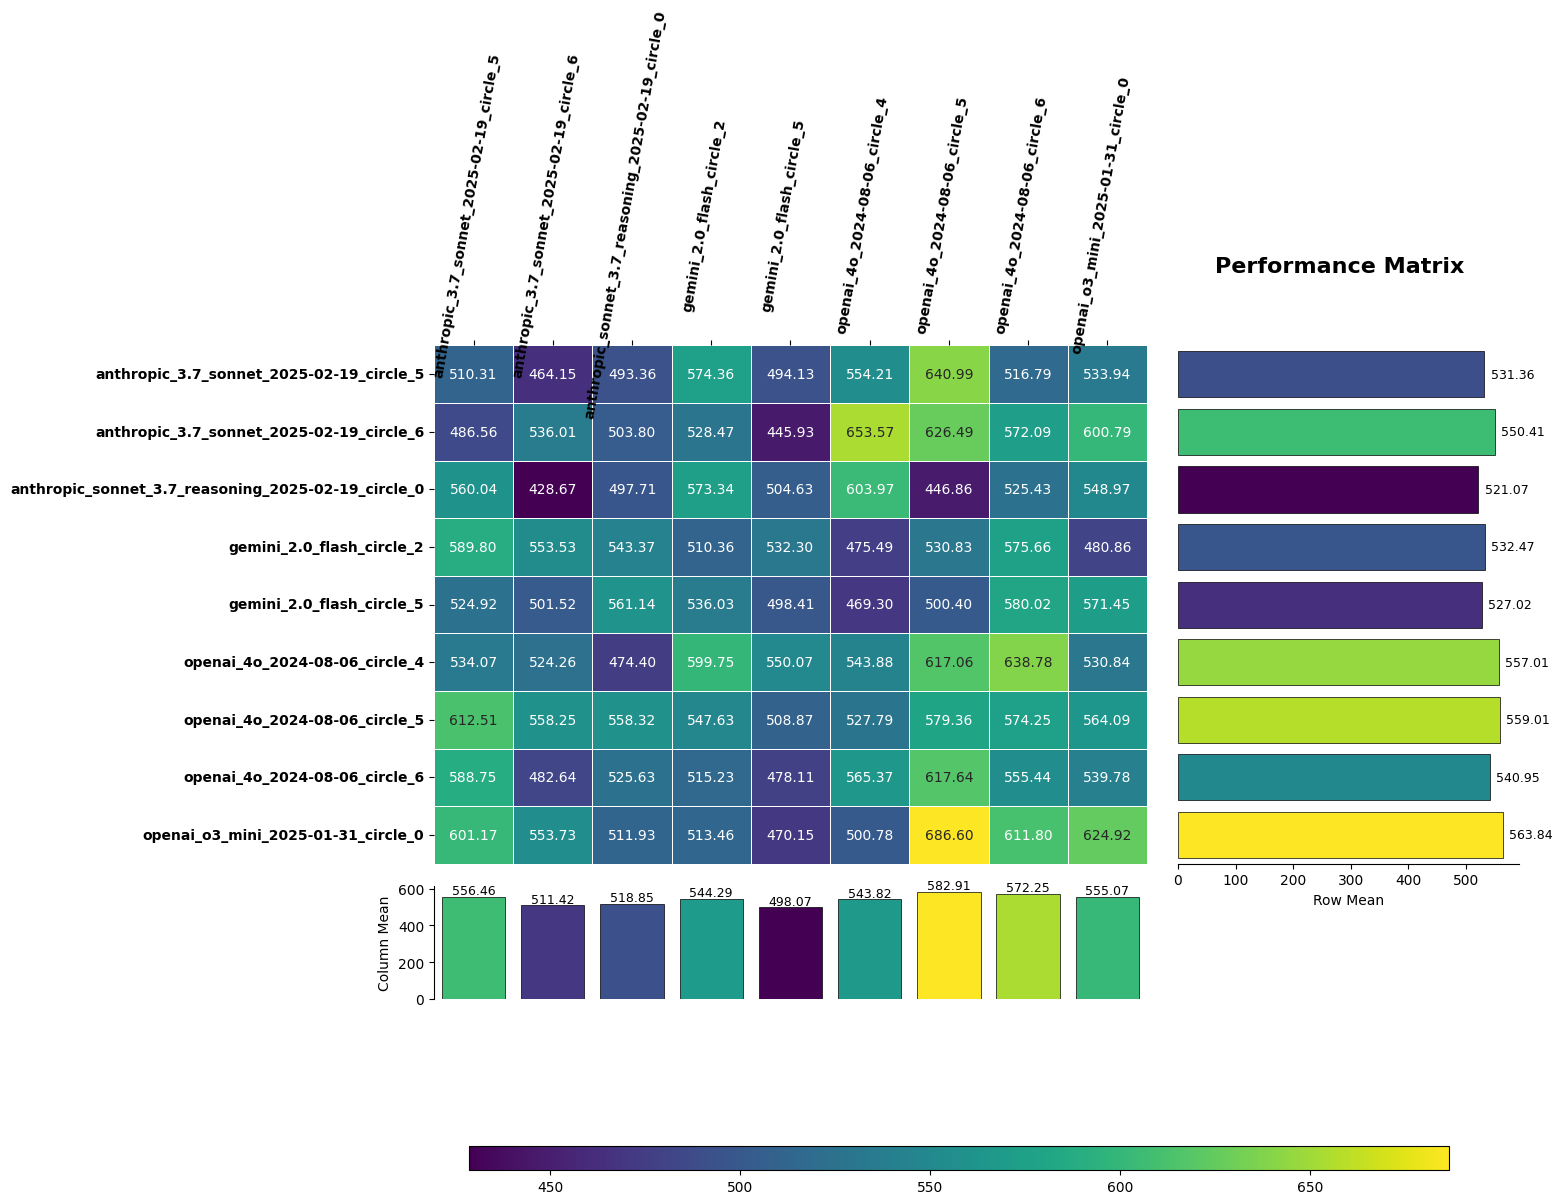

Calculating means for Nash Welfare Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

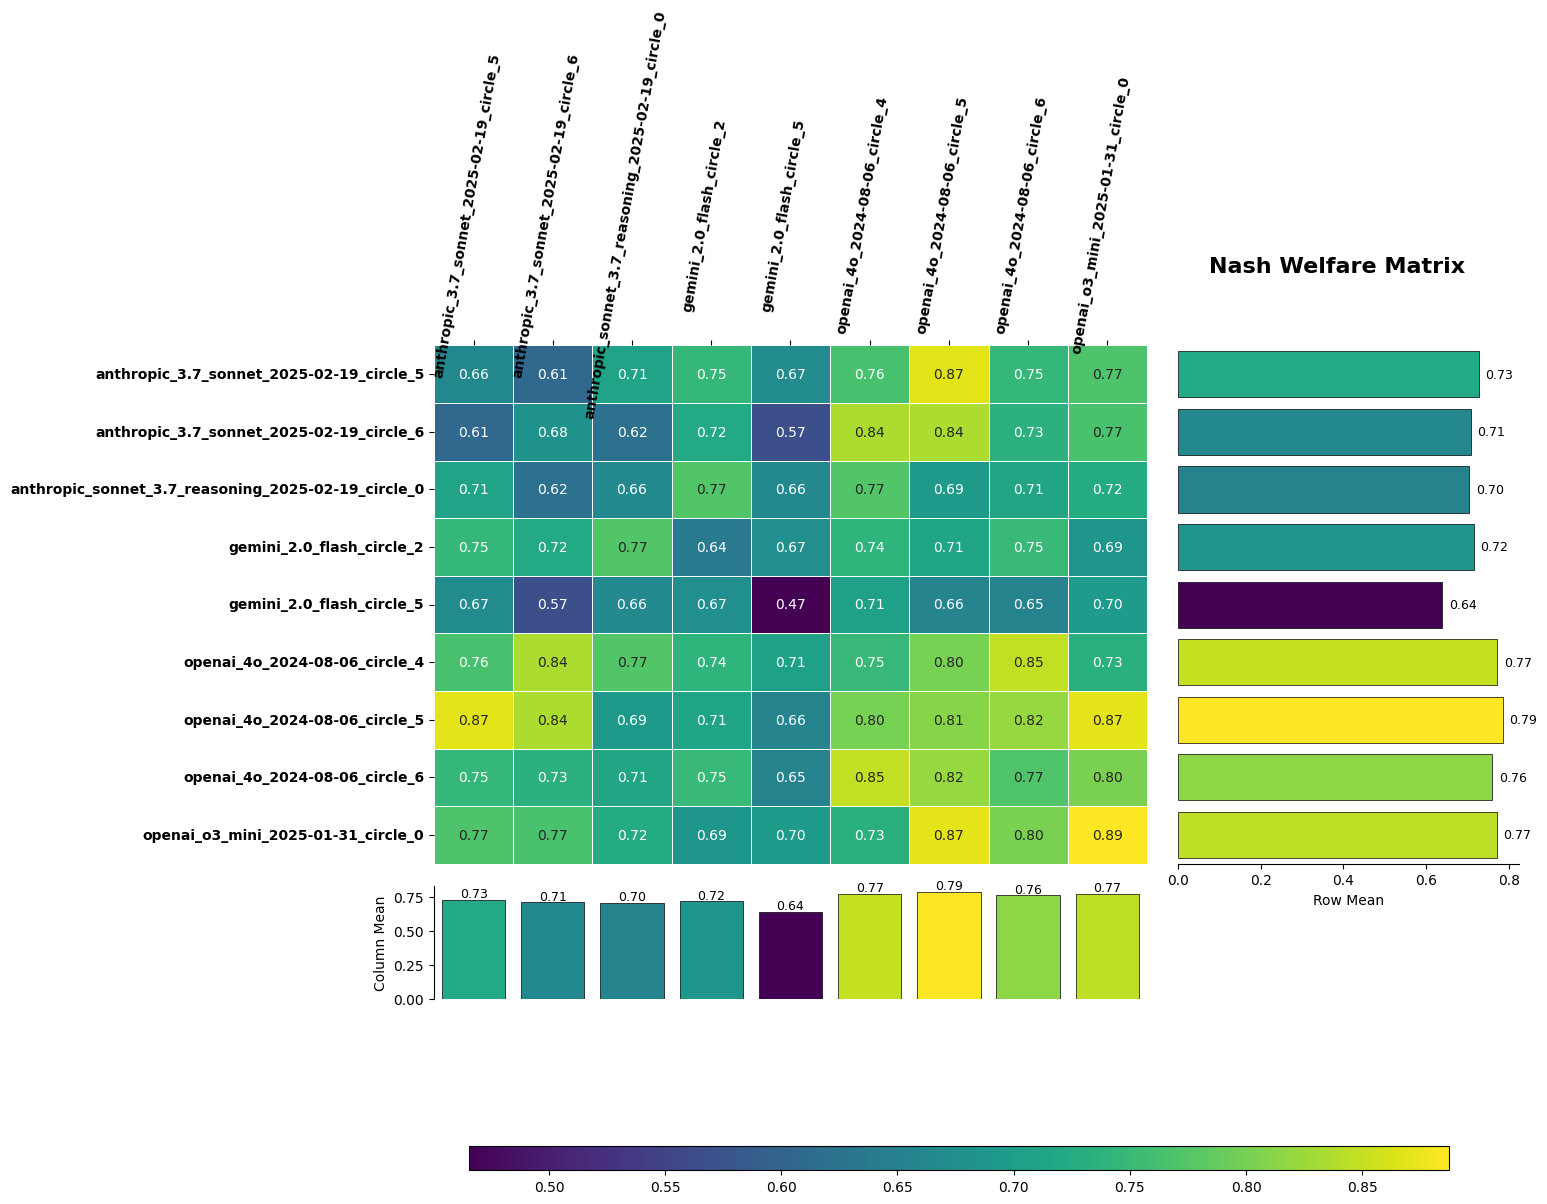

Calculating means for Utilitarian Welfare Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

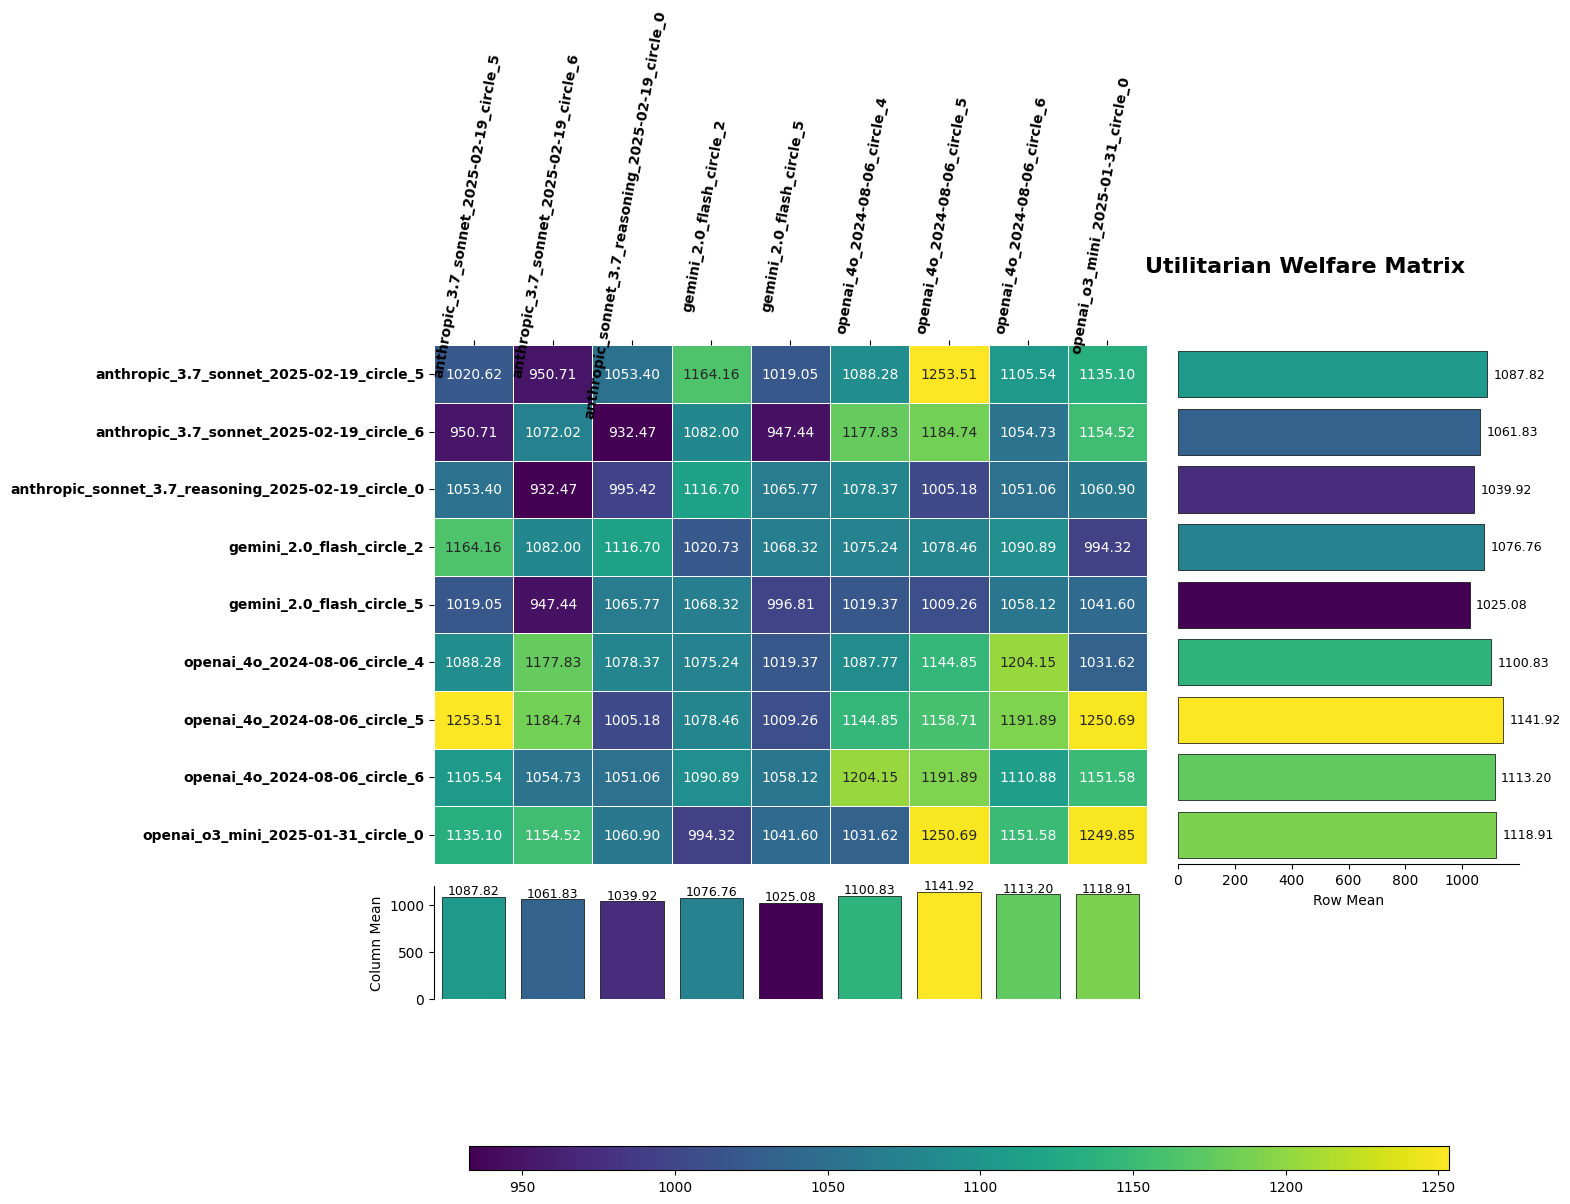

Calculating means for Rawls Welfare Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

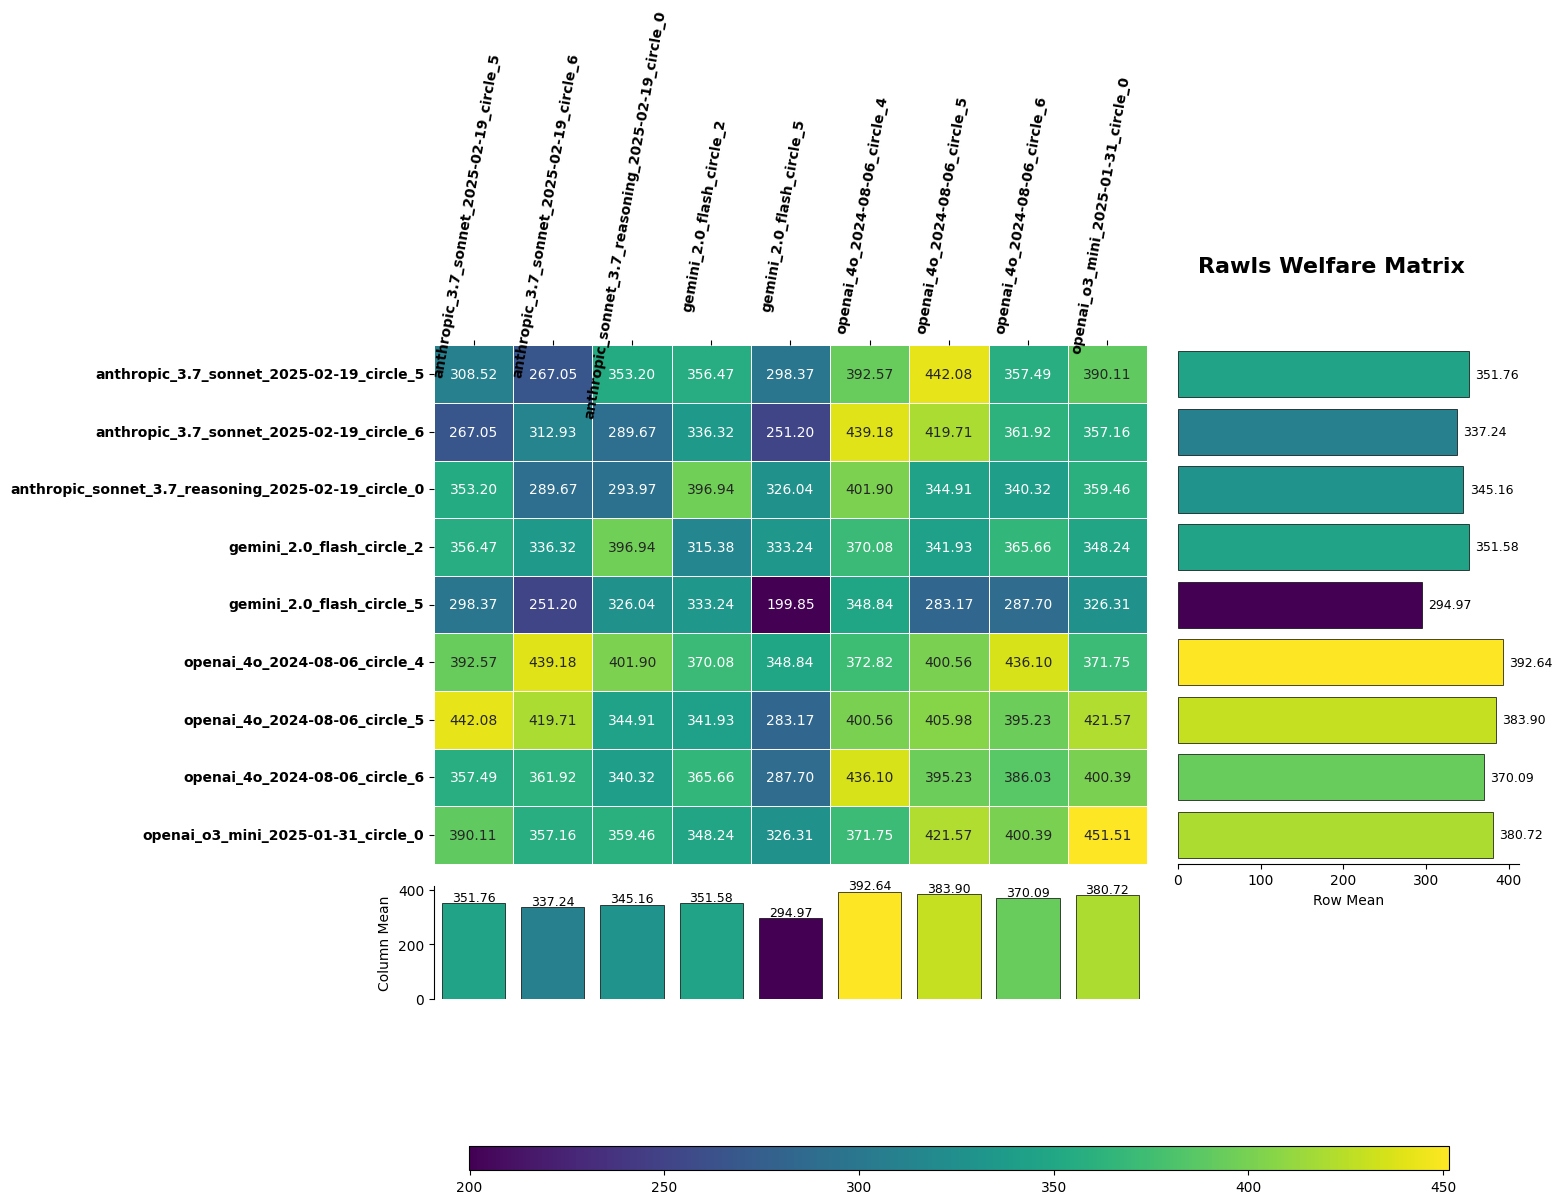

Calculating means for Gini Coefficient Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

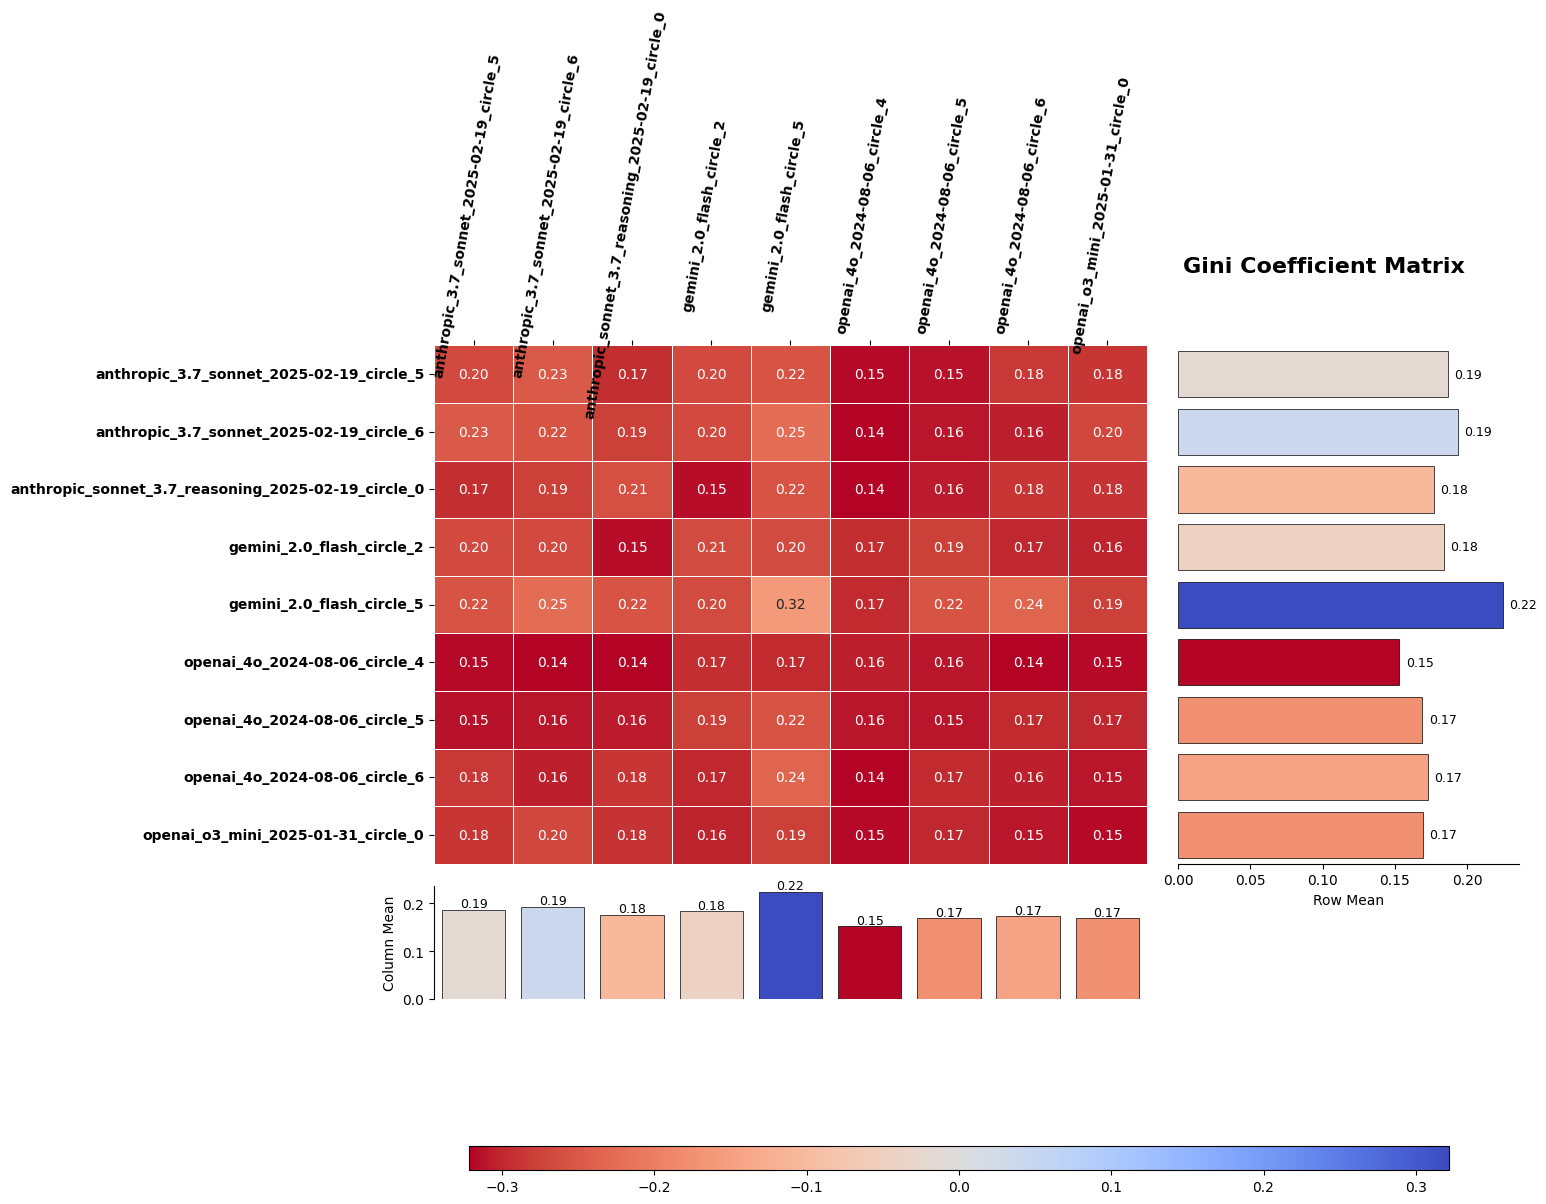

Calculating means for Jain's Fairness Index Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

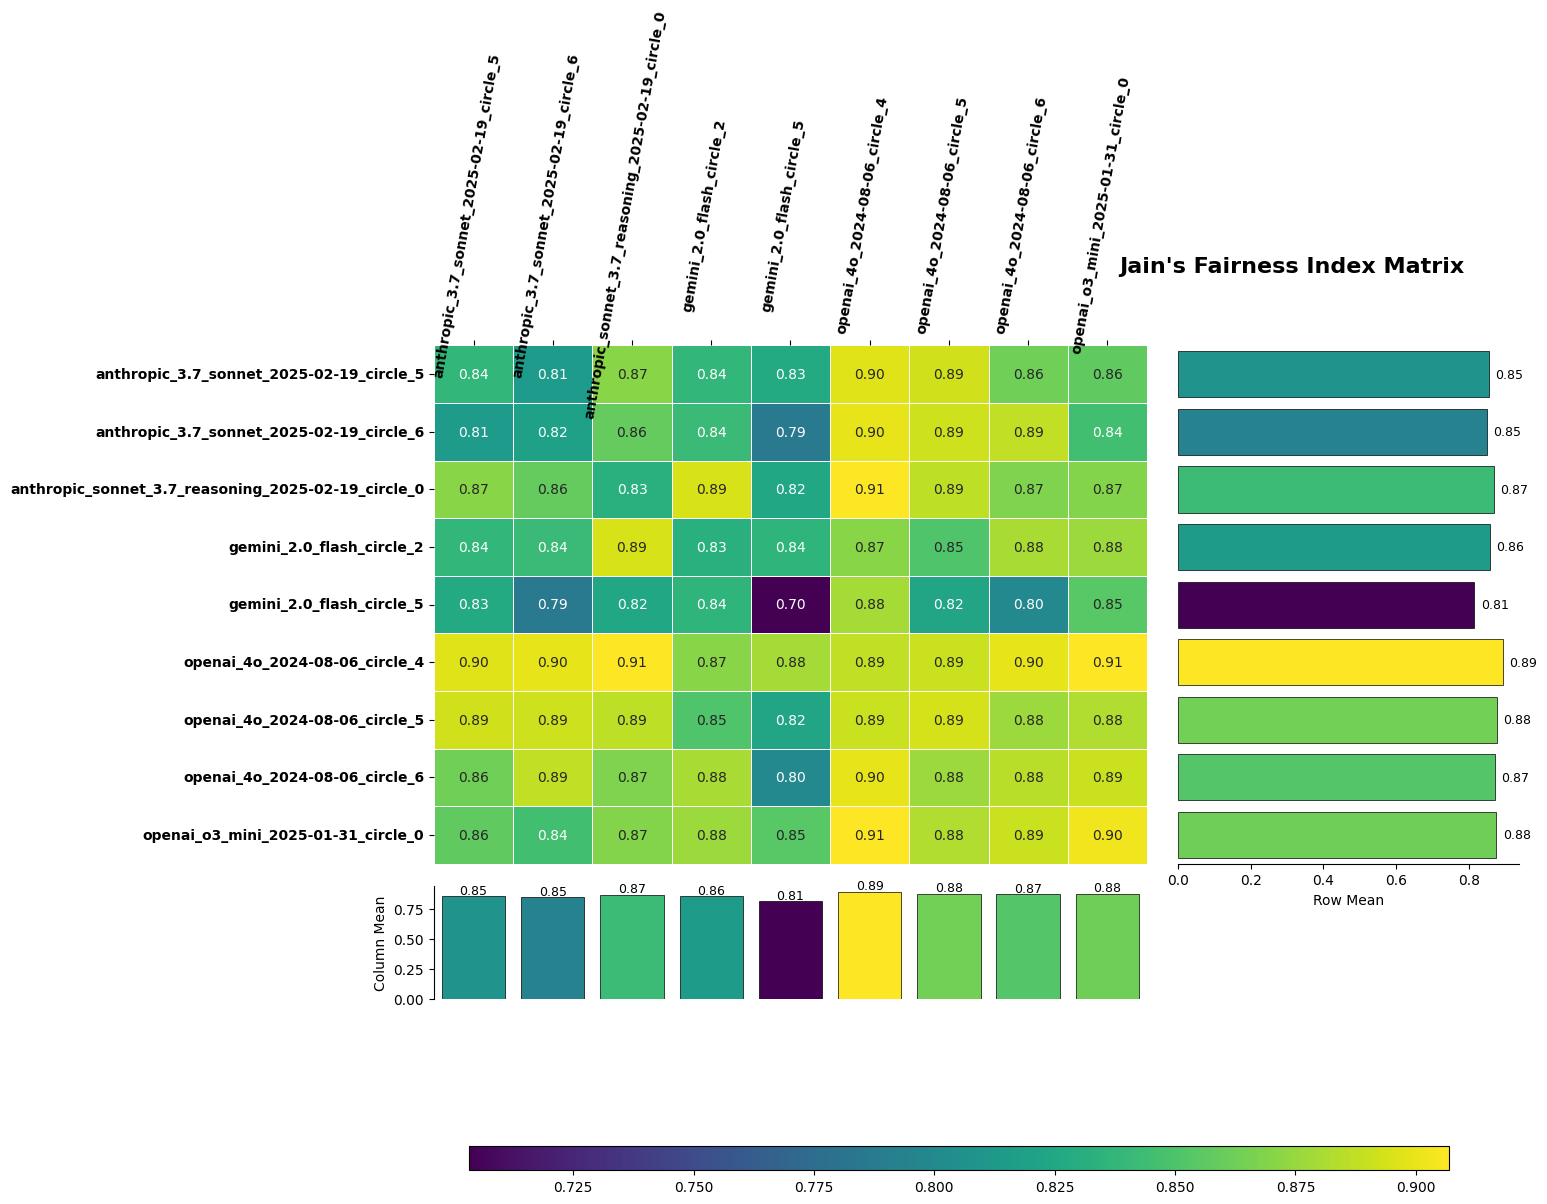

Calculating means for Envy-Free Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

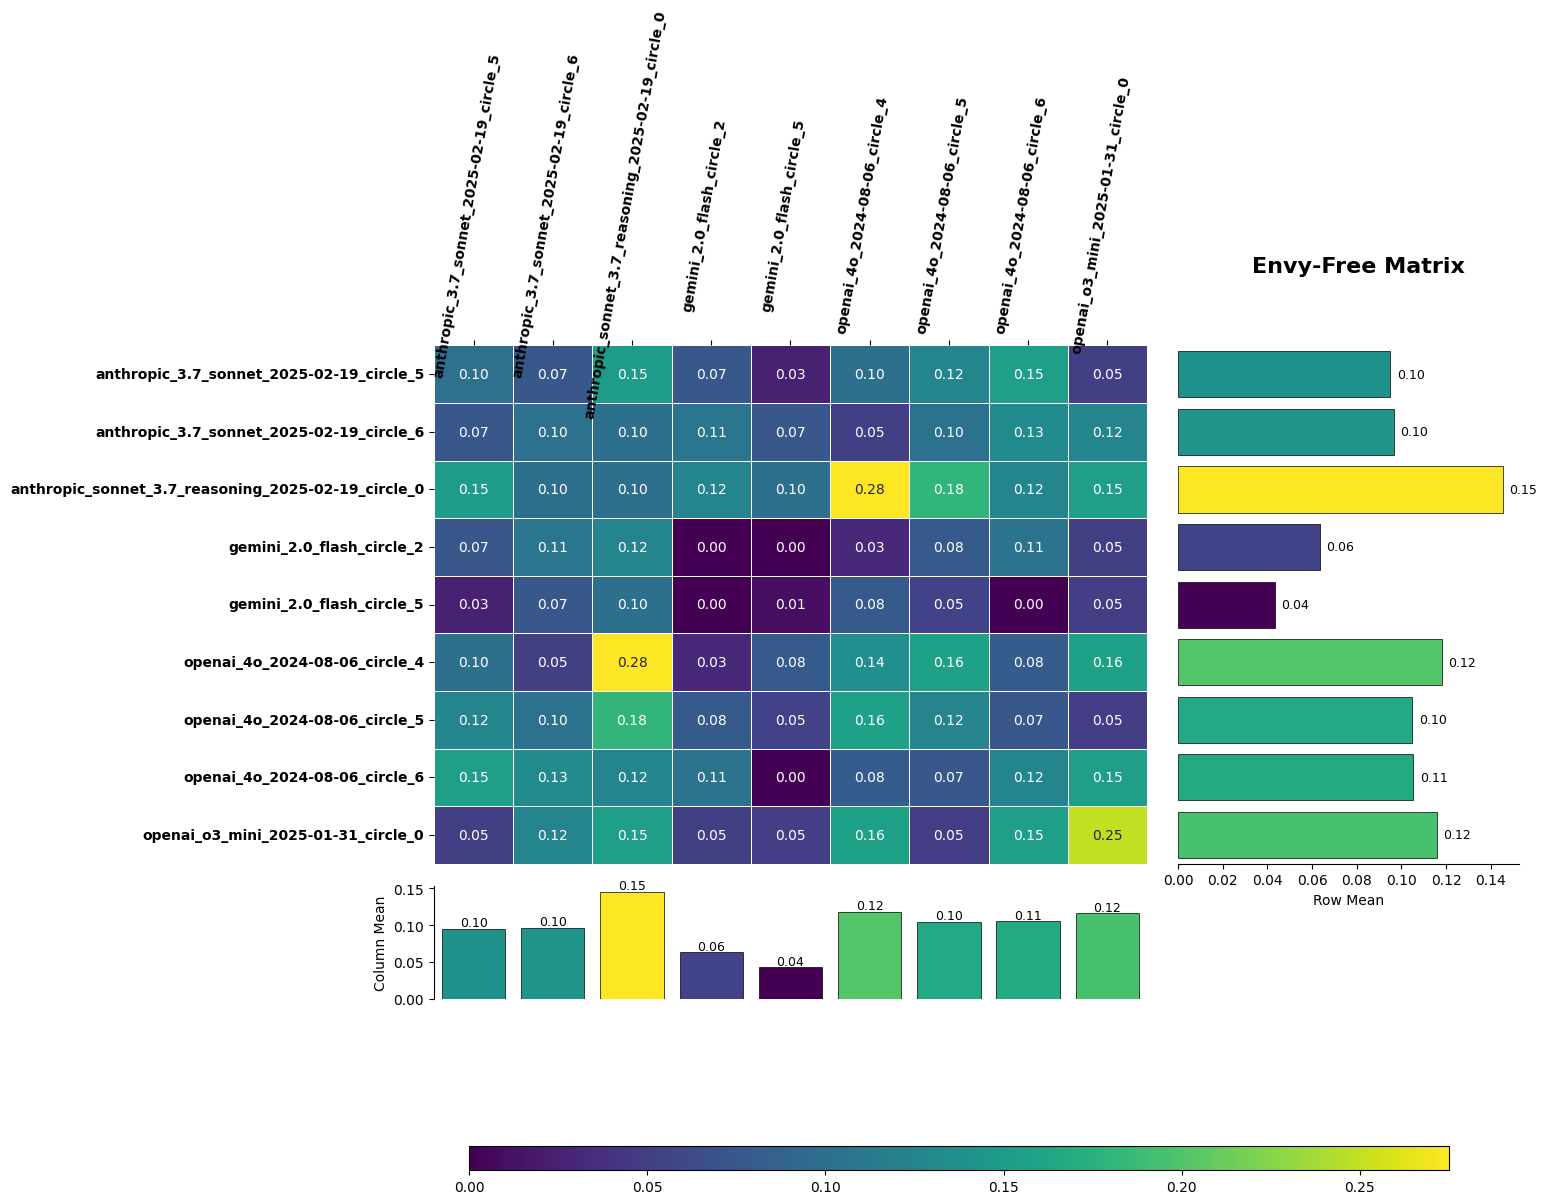

Calculating means for EF1 Matrix:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

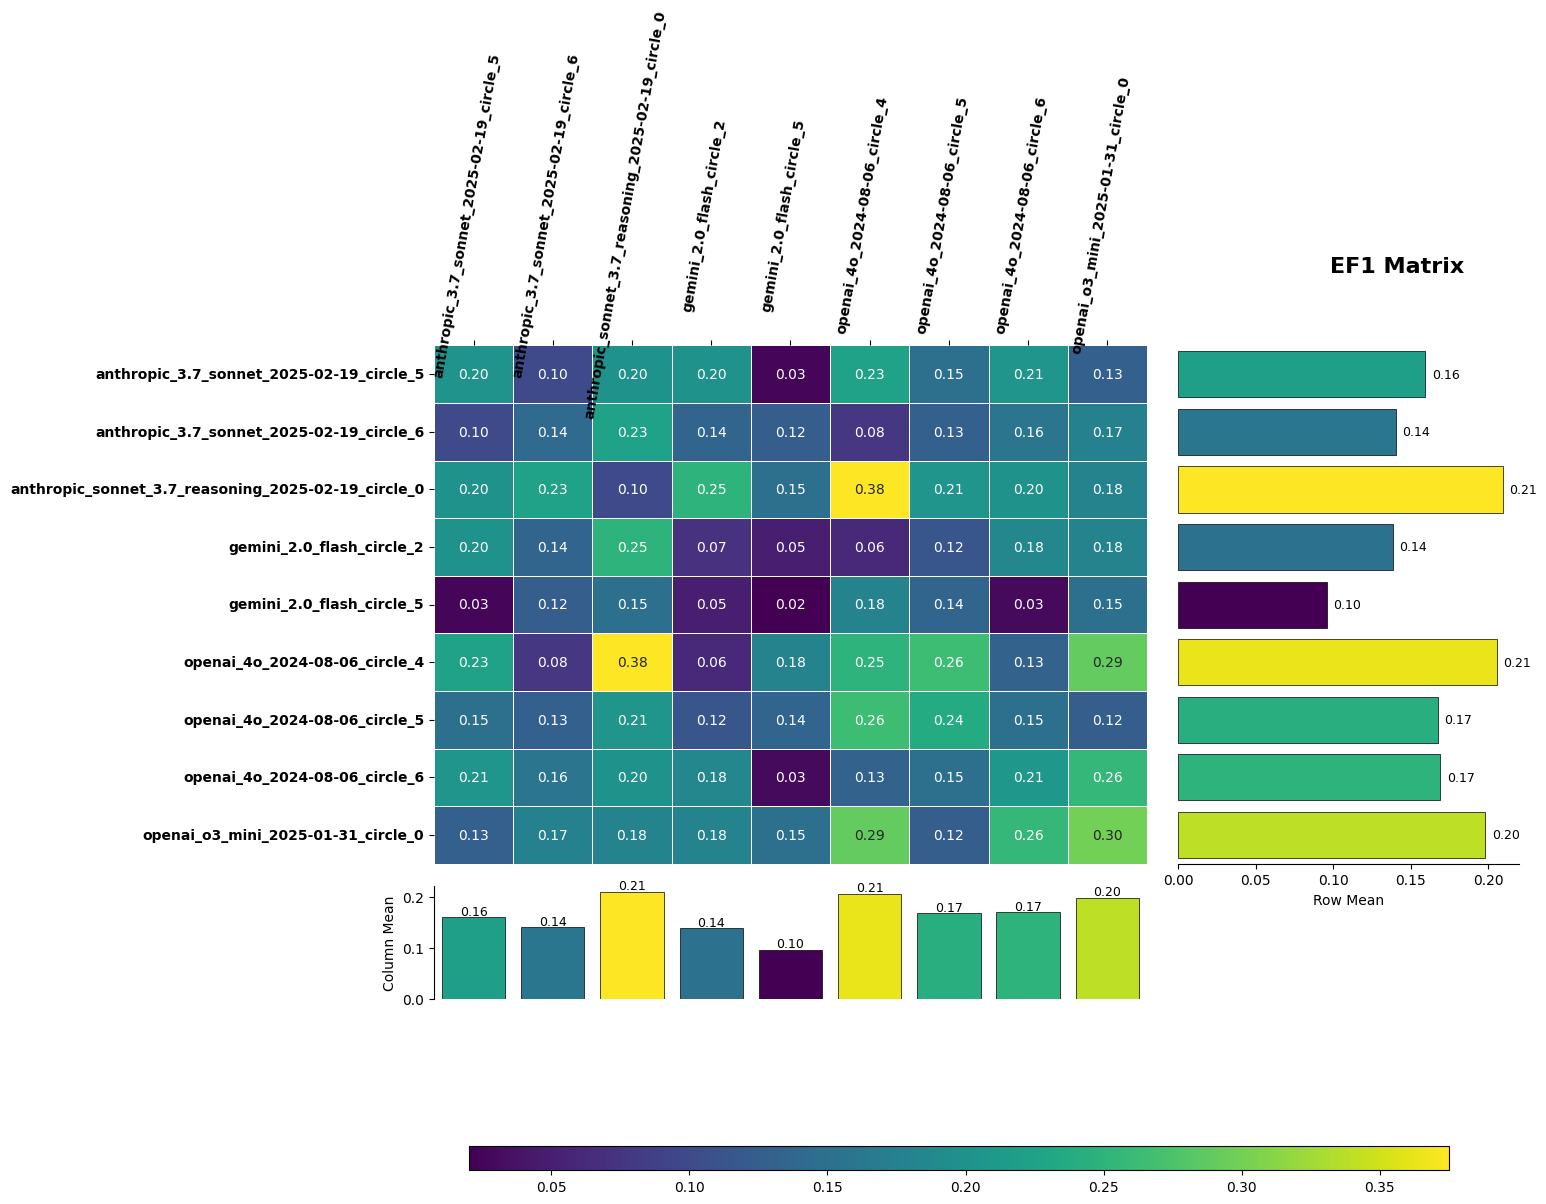

Calculating means for Pareto-Front-Count:
Example row (openai_4o_circle_4 if available):


/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(color_norm)
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_59318/2594336687.py:175: UserWa

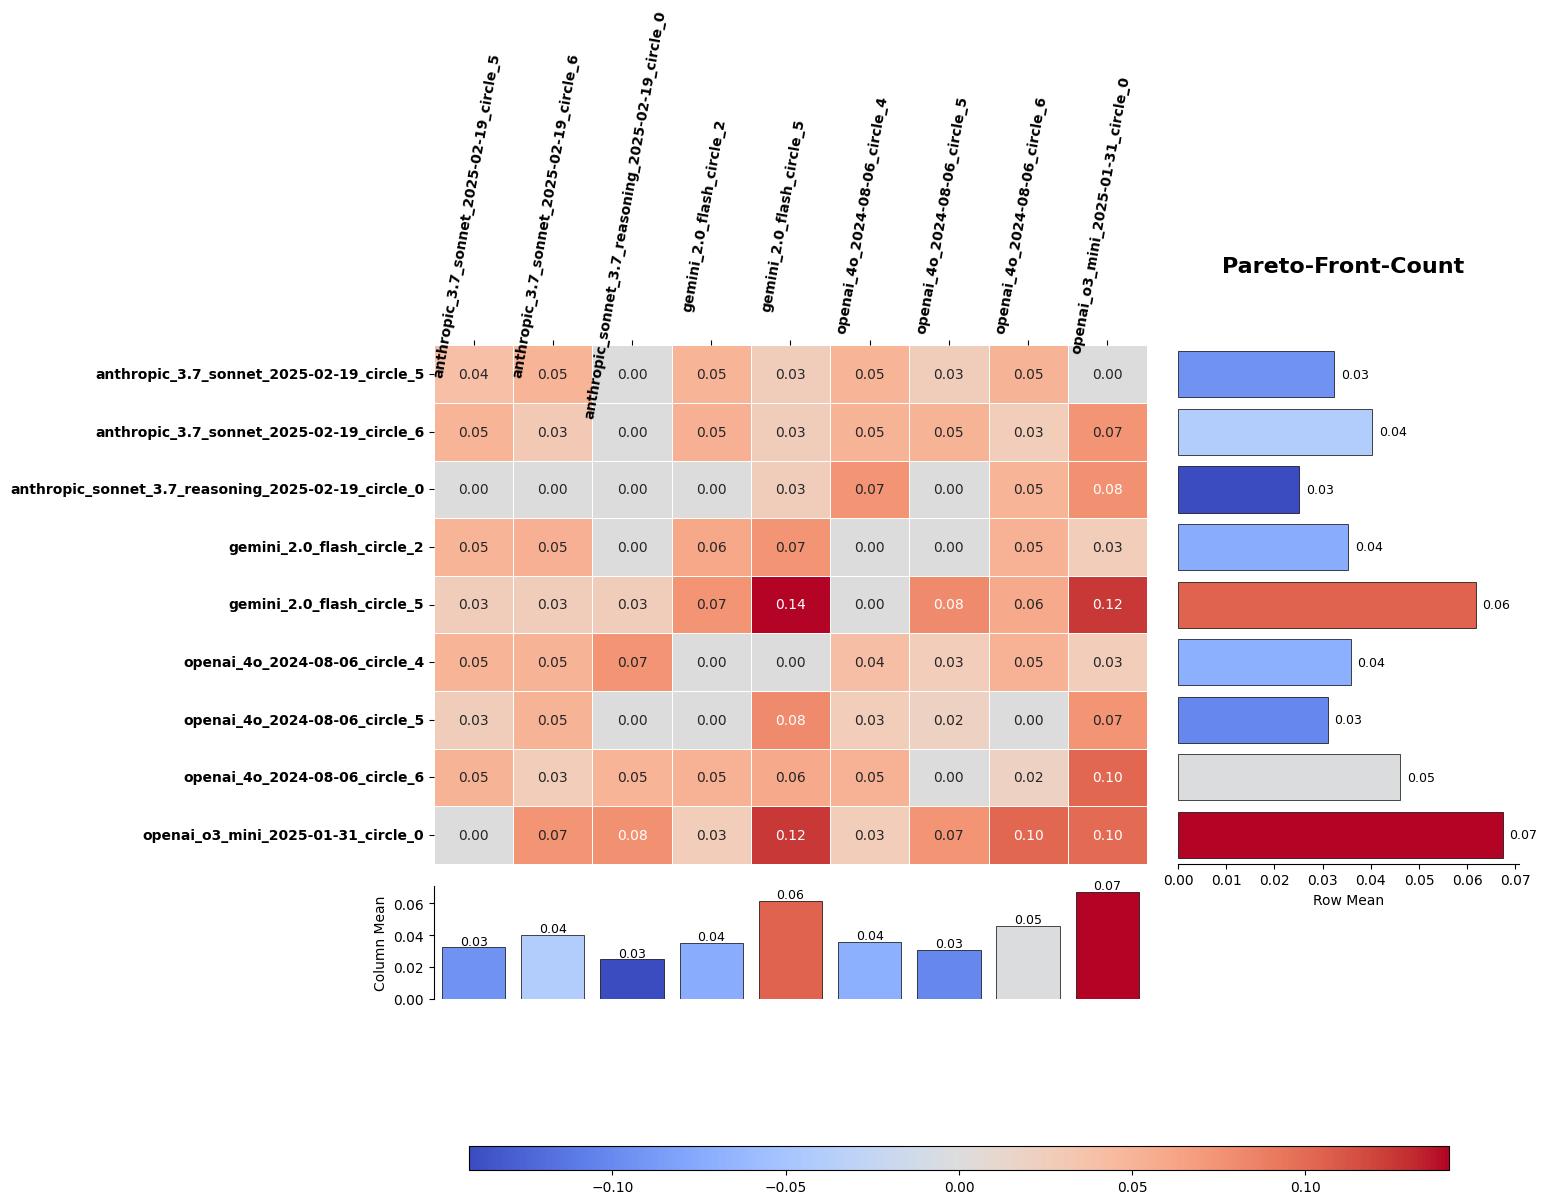

In [19]:
for matrix_name, matrix in [
    ("Performance Matrix", performance_matrix),
    ("Nash Welfare Matrix", nash_welfare_matrix),
    ("Utilitarian Welfare Matrix", utilitarian_welfare_matrix),
    ("Rawls Welfare Matrix", rawls_welfare_matrix),
    ("Gini Coefficient Matrix", gini_matrix),
    ("Jain's Fairness Index Matrix", jain_matrix),
    ("Envy-Free Matrix", envy_free_matrix),
    ("EF1 Matrix", ef1_matrix),
    ("Pareto-Front-Count", pareto_matrix)
]:
    if matrix_name in ["Performance Matrix", "Nash Welfare Matrix", 
                       "Utilitarian Welfare Matrix", 
                       "Rawls Welfare Matrix"]:
        cmap = "viridis" 
        center = None
    elif matrix_name in ["Gini Coefficient Matrix"]:
        cmap = "coolwarm_r"
        center = 0.5
    elif matrix_name in ["Jain's Fairness Index Matrix", "Envy-Free Matrix", "EF1 Matrix"]:
        cmap = "viridis"
        center = None
    else:
        cmap = "coolwarm"
        center = 0
    
    fig = create_matrix_heatmap_with_marginals(matrix, title=matrix_name, cmap=cmap, center=center)
    plt.show()

## Visuals of Cooperation

### Cooperation Graphs

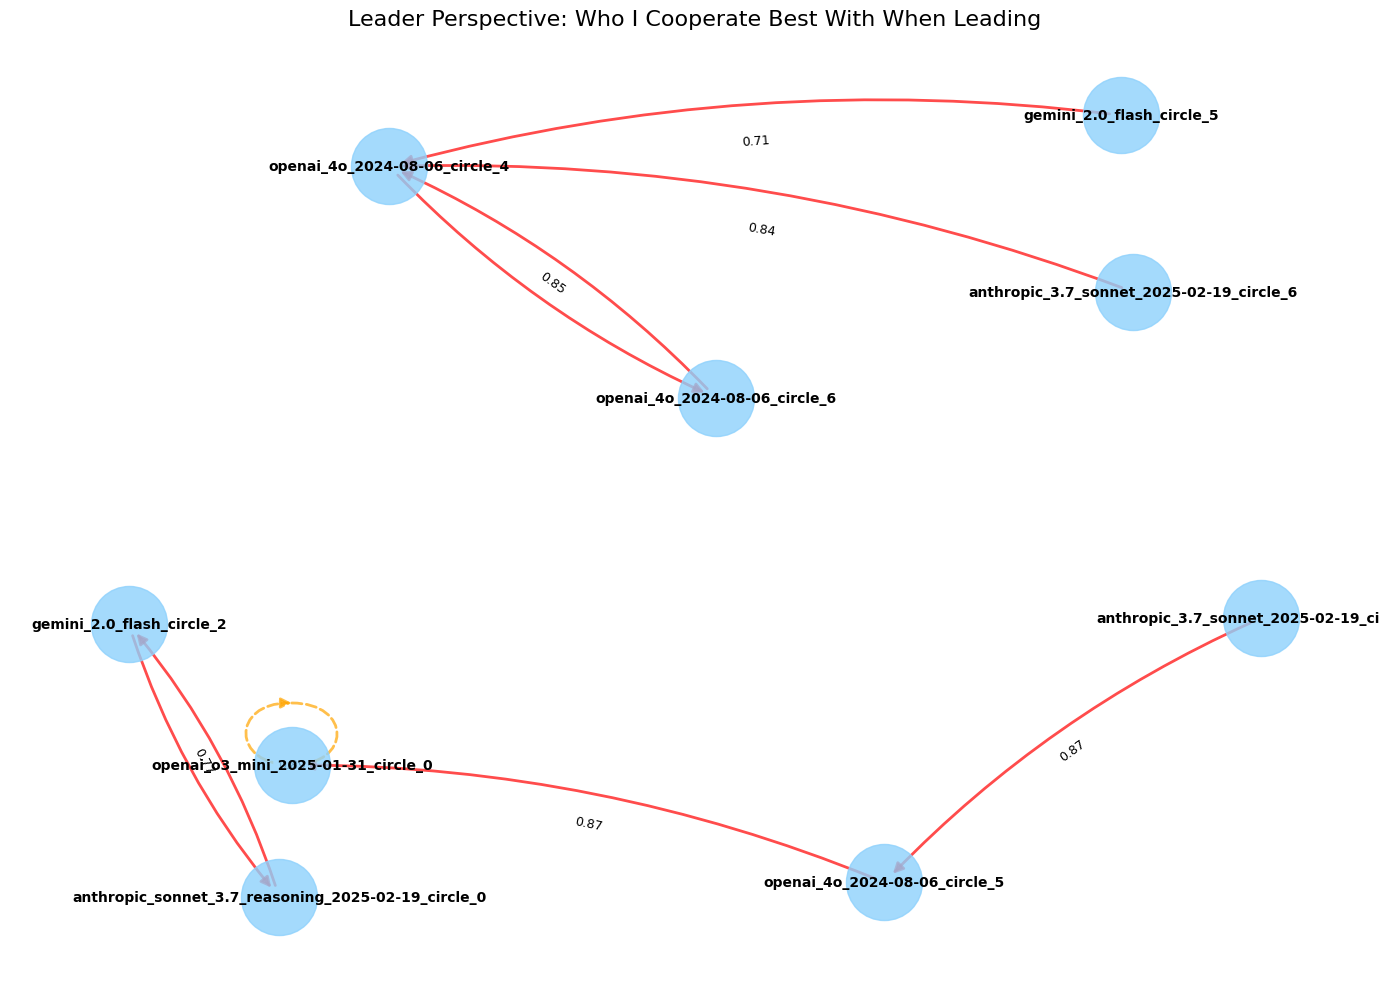

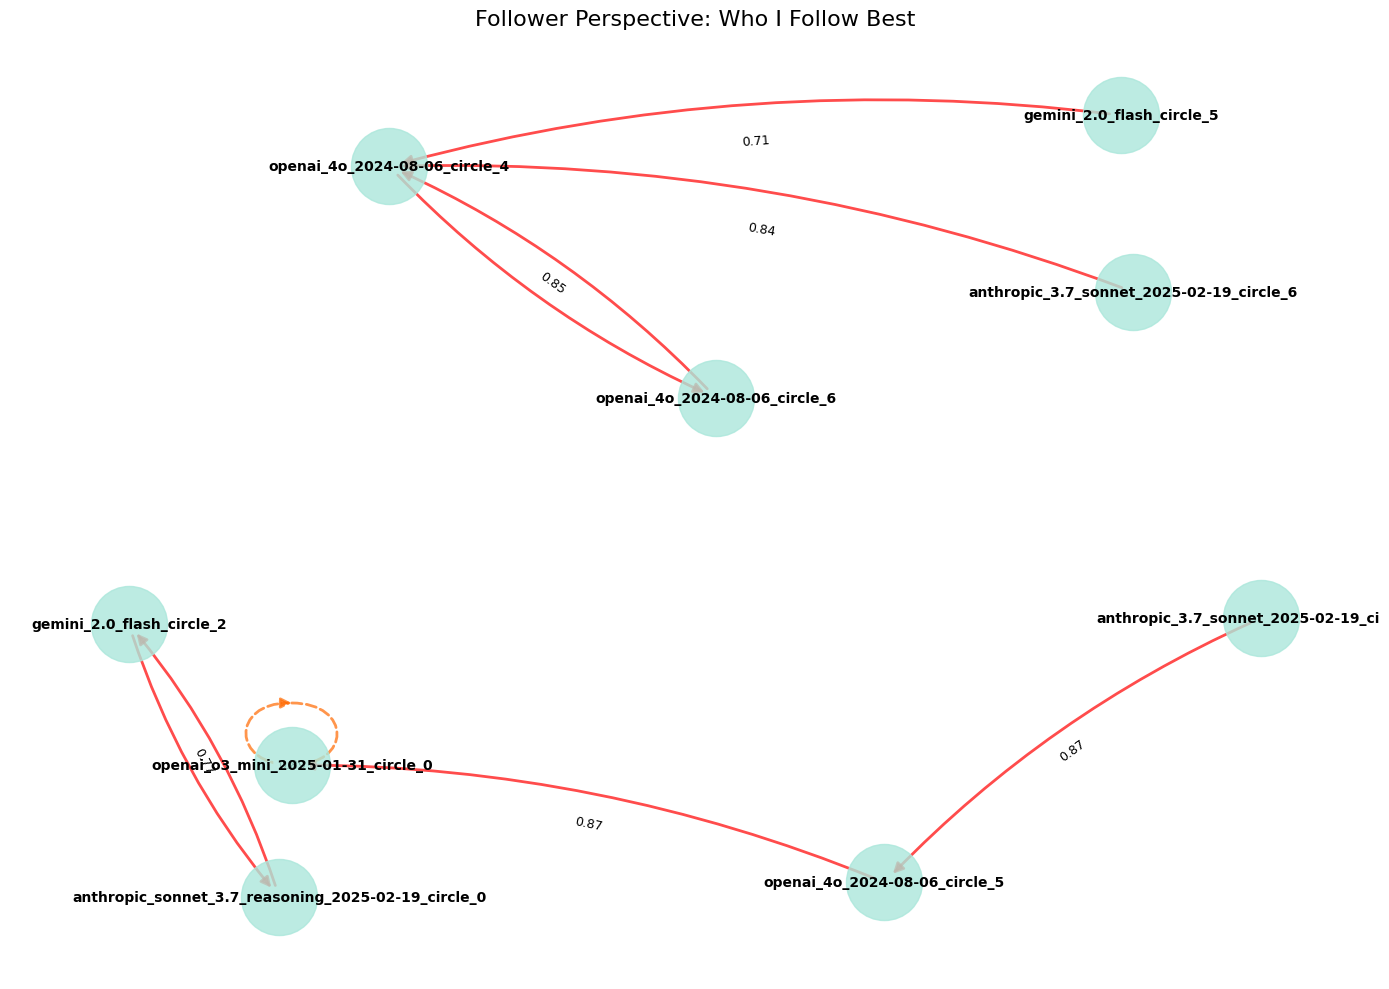

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create two specialized cooperation graphs - one for leaders, one for followers
def create_leader_perspective_graph(welfare_matrix, top_n=2):
    """Shows who each agent cooperates best with when they are the leader"""
    G = nx.DiGraph()
    agents = welfare_matrix.columns.tolist()
    
    for agent in agents:
        G.add_node(agent)
    
    # For each agent as a leader (row perspective)
    for leader in agents:
        # Get welfare values when this agent leads
        welfare_values = welfare_matrix.loc[leader]
        
        # Sort followers by welfare
        top_followers = welfare_values.sort_values(ascending=False)
        
        # Add edges to top N followers (INCLUDING self if it ranks highly)
        count = 0
        for follower, welfare in top_followers.items():
            if count < top_n and not np.isnan(welfare):  # Removed follower != leader check
                G.add_edge(leader, follower, weight=welfare)
                count += 1
    
    # Create plot
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42, k=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='#8ED1FC', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw regular edges
    regular_edges = [(u, v) for u, v in G.edges() if u != v]
    nx.draw_networkx_edges(G, pos, edgelist=regular_edges, width=2, alpha=0.7, 
                          edge_color='red', connectionstyle='arc3,rad=0.1', arrowsize=15)
    
    # Draw self-loops with a different style
    self_loops = [(u, v) for u, v in G.edges() if u == v]
    nx.draw_networkx_edges(G, pos, edgelist=self_loops, width=2, alpha=0.7,
                          edge_color='orange', connectionstyle='arc3,rad=0.3', arrowsize=15, style='dashed')
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    
    plt.title("Leader Perspective: Who I Cooperate Best With When Leading", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    return plt

def create_follower_perspective_graph(welfare_matrix, top_n=2):
    """Shows who each agent cooperates best with when they are the follower"""
    G = nx.DiGraph()
    agents = welfare_matrix.columns.tolist()
    
    for agent in agents:
        G.add_node(agent)
    
    for follower in agents:
        welfare_values = welfare_matrix[follower]  # Column values
        
        top_leaders = welfare_values.sort_values(ascending=False)
        
        # Add edges FROM follower TO leader (follower → leader)
        count = 0
        for leader, welfare in top_leaders.items():
            if count < top_n and not np.isnan(welfare):  
                
                G.add_edge(follower, leader, weight=welfare)
                count += 1
    
    # Create plot
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42, k=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='#ABE7DB', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw regular edges
    regular_edges = [(u, v) for u, v in G.edges() if u != v]
    nx.draw_networkx_edges(G, pos, edgelist=regular_edges, width=2, alpha=0.7, 
                          edge_color='red', connectionstyle='arc3,rad=0.1', arrowsize=15)
    
    # Draw self-loops with a different style
    self_loops = [(u, v) for u, v in G.edges() if u == v]
    nx.draw_networkx_edges(G, pos, edgelist=self_loops, width=2, alpha=0.7,
                          edge_color='#FF6900', connectionstyle='arc3,rad=0.3', arrowsize=15, style='dashed')
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    
    plt.title("Follower Perspective: Who I Follow Best", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    return plt

leader_plot = create_leader_perspective_graph(nash_welfare_matrix, top_n=1)
leader_plot.show()


follower_plot = create_follower_perspective_graph(nash_welfare_matrix, top_n=1)
follower_plot.show()



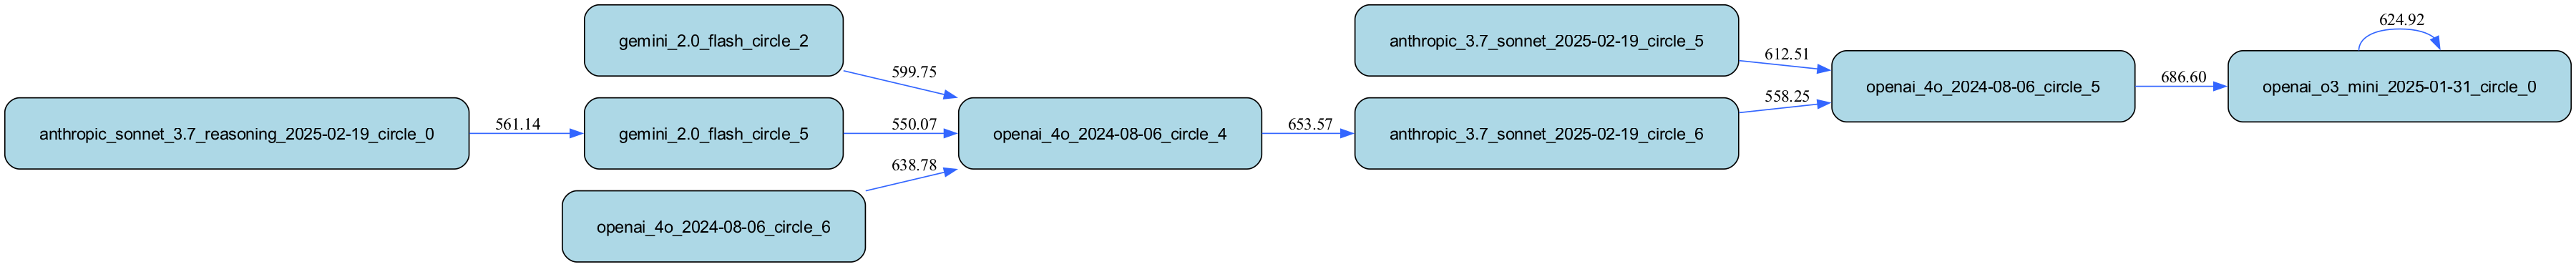

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

# Assuming performance_matrix is your existing pandas DataFrame
# Create a new Graphviz graph
dot = Digraph(comment='Strategy Response Graph', format='png')
dot.attr(rankdir='LR', size='12,8', dpi='300', bgcolor='white')
dot.attr('node', shape='box', style='filled,rounded', fillcolor='lightblue', 
         fontname='Arial', fontsize='14', margin='0.4,0.3')  # Increased margin to prevent text cutoff

# Get strategy names from your DataFrame
strategy_names = performance_matrix.columns.tolist()

# Add nodes with cleaner labels (shorten if needed)
for strategy in strategy_names:
    # Create a shorter label if the strategy name is too long
    short_name = strategy
    # if len(strategy) > 15:  # Reduced character limit to ensure text fits
    #     short_name = strategy[:12] + "..."
    
    # Add more padding by using HTML-like label with line breaks if needed
    dot.node(strategy, short_name, width='2.5', height='0.8')

# For each strategy (column), find the best response (highest value in column)
for strategy in strategy_names:
    # Get the column values
    column_values = performance_matrix[strategy]
    
    # Find the index of the best response (highest value)
    best_response = column_values.idxmax()
    best_value = column_values.max()
    
    # Add an edge from the strategy to its best response
    dot.edge(strategy, best_response, label=f" {best_value:.2f}", color='#3366FF')

# Render the graph
dot.render('strategy_graph_graphviz', view=True, cleanup=True)

# If you want to display it in the notebook
from IPython.display import Image, display
display(Image('strategy_graph_graphviz.png'))

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

def create_complete_best_response_graph(performance_matrix, filename='complete_best_response'):
    """
    Create a complete best response graph showing both player perspectives
    
    Parameters:
    - performance_matrix: DataFrame containing payoffs (rows are P1 strategies, columns are P2 strategies)
    - filename: base name for output files
    """
    # Create a new Graphviz graph
    dot = Digraph(comment='Complete Best Response Graph', format='png')
    dot.attr(rankdir='LR', size='14,10', dpi='300', bgcolor='white')
    dot.attr('node', shape='box', style='filled,rounded', fontname='Arial', fontsize='14', margin='0.4,0.3')
    
    # Get strategy names
    strategy_names = performance_matrix.columns.tolist()
    
    # Add nodes with distinct colors based on which player has best response
    for strategy in strategy_names:
        # Add the node once - we'll color edges instead of nodes to show perspectives
        dot.node(strategy, strategy, width='2.5', height='0.8', fillcolor='lightblue')
    
    # Add P1 best responses (respond to P2's strategies - column perspective)
    for p2_strategy in strategy_names:
        # Get the column values - what P1 gets against P2's strategy
        p1_payoffs = performance_matrix[p2_strategy]
        
        # Find P1's best response
        p1_best_response = p1_payoffs.idxmax()
        p1_best_value = p1_payoffs.max()
        
        # Add edge from P2 strategy to P1's best response (P2 → P1 best response)
        dot.edge(p2_strategy, p1_best_response, 
                label=f" P1:{p1_best_value:.2f}", 
                color='#3366FF',  # Blue for P1's best responses
                fontcolor='#3366FF')
    
    # Add P2 best responses (respond to P1's strategies - row perspective)
    # We need to transpose performance_matrix to get P2's perspective
    p2_matrix = performance_matrix.transpose()  # Now rows are P2 strategies, columns are P1 strategies
    
    for p1_strategy in strategy_names:
        # Get the column values - what P2 gets against P1's strategy
        p2_payoffs = p2_matrix[p1_strategy]
        
        # Find P2's best response
        p2_best_response = p2_payoffs.idxmax()
        p2_best_value = p2_payoffs.max()
        
        # Add edge from P1 strategy to P2's best response (P1 → P2 best response)
        dot.edge(p1_strategy, p2_best_response, 
                label=f" P2:{p2_best_value:.2f}", 
                color='#FF6347',  # Red for P2's best responses
                fontcolor='#FF6347')
    
    # Render the graph
    dot.render(filename, view=True, cleanup=True)
    
    # Return the Digraph object for potential further customization
    return dot

# Example usage:
best_response_graph = create_complete_best_response_graph(performance_matrix)

## Statistical Analysis

In [23]:
def analyze_game_progression(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    progression_data = []
    
    for game_idx, game in enumerate(data['all_game_data']):
        agent1 = game['agent1']
        agent2 = game['agent2']
        
        # Remove Agent1_ and Agent2_ prefixes if they exist
        if agent1.startswith("Agent1_"):
            agent1 = agent1[7:]
        if agent2.startswith("Agent2_"):
            agent2 = agent2[7:]
        
        # Extract circle values
        try:
            circle_data = game['circle']
            if isinstance(circle_data, int):
                p1_circle = circle_data
                p2_circle = circle_data
            else:
                p1_circle = circle_data[0]
                p2_circle = circle_data[1]
        except (KeyError, TypeError, IndexError):
            p1_circle = None
            p2_circle = None
        
        # Add circle values to agent names
        agent1_with_circle = f"{agent1}_circle_{p1_circle}" if p1_circle is not None else agent1
        agent2_with_circle = f"{agent2}_circle_{p2_circle}" if p2_circle is not None else agent2
        
        # Extract private values and outside offers
        p1_values = None
        p2_values = None
        p1_outside_offer = None
        p2_outside_offer = None
        num_items = None
        
        game_rounds = []
        current_offer = None
        
        for round_idx, round_data in enumerate(game['round_data']):
            round_number = (round_idx // 2) + 1
            turn_in_round = (round_idx % 2) + 1
            action = round_data['action']
            prompt = round_data['prompt']
            
            # Determine active player
            active_player = agent1_with_circle if "You are Player 1" in prompt else agent2_with_circle
            
            # Extract values and outside offers first time we see them
            if p1_values is None and "You are Player 1" in prompt:
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p1_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p1_outside_offer = parse_outside_offer(line)
                    elif "There are" in line and "units of item" in line:
                        if num_items is None:
                            nums = []
                            parts = line.split("There are ")[1].split(", ")
                            for part in parts:
                                num = int(part.split(" units")[0])
                                nums.append(num)
                            num_items = nums
            
            if p2_values is None and "You are Player 2" in prompt:
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p2_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p2_outside_offer = parse_outside_offer(line)
            
            # Extract current offer on the table
            offer_before_action = None
            if "Current offer on the table" in prompt:
                offer_line = prompt.split("Current offer on the table")[1].split("\n")[0]
                if "None" not in offer_line and "[" in offer_line:
                    offer_before_action = eval(offer_line[offer_line.find("["):offer_line.find("]")+1])
            
            # Process the action
            if action.startswith("OFFER"):
                try:
                    new_offer = eval(action.replace("OFFER ", ""))
                    current_offer = new_offer
                except:
                    new_offer = "INVALID OFFER"
            elif action == "ACCEPT":
                # Calculate utilities based on current offer
                p1_items = None
                p2_items = None
                
                if turn_in_round == 1:  # Player 1 accepting
                    p1_items = offer_before_action
                    p2_items = [num_items[i] - offer_before_action[i] for i in range(len(offer_before_action))]
                else:  # Player 2 accepting
                    p2_items = offer_before_action
                    p1_items = [num_items[i] - offer_before_action[i] for i in range(len(offer_before_action))]
                
                # Calculate utilities
                discount_factor = 0.9 ** (round_number - 1)
                p1_utility = calculate_value(p1_items, p1_values) * discount_factor if p1_items else None
                p2_utility = calculate_value(p2_items, p2_values) * discount_factor if p2_items else None
            elif action == "WALK" or action == "INVALID WALK":
                # Calculate outside offer values
                discount_factor = 0.9 ** (round_number - 1)
                p1_utility = p1_outside_offer * discount_factor if p1_outside_offer else None
                p2_utility = p2_outside_offer * discount_factor if p2_outside_offer else None
            else:
                p1_utility = None
                p2_utility = None
            
            # Calculate utility if the offer was accepted at this point
            potential_p1_utility = None
            potential_p2_utility = None
            
            if current_offer is not None and p1_values and p2_values:
                discount_factor = 0.9 ** (round_number - 1)
                if turn_in_round == 1:  # From Player 1's perspective
                    p1_potential_items = current_offer
                    p2_potential_items = [num_items[i] - current_offer[i] for i in range(len(current_offer))]
                else:  # From Player 2's perspective
                    p2_potential_items = current_offer
                    p1_potential_items = [num_items[i] - current_offer[i] for i in range(len(current_offer))]
                
                potential_p1_utility = calculate_value(p1_potential_items, p1_values) * discount_factor
                potential_p2_utility = calculate_value(p2_potential_items, p2_values) * discount_factor
            
            # Track results for this round
            round_info = {
                'game_id': game_idx,
                'round': round_number,
                'turn': turn_in_round,
                'active_player': active_player,
                'action': action,
                'offer_before_action': offer_before_action,
                'current_offer': current_offer,
                'p1_utility': p1_utility,
                'p2_utility': p2_utility,
                'potential_p1_utility': potential_p1_utility,
                'potential_p2_utility': potential_p2_utility,
                'discount_factor': 0.9 ** (round_number - 1),
            }
            
            game_rounds.append(round_info)
        
        # Add game-level data
        game_data = {
            'game_id': game_idx,
            'agent1': agent1_with_circle,
            'agent2': agent2_with_circle,
            'p1_values': p1_values,
            'p2_values': p2_values,
            'p1_outside_offer': p1_outside_offer,
            'p2_outside_offer': p2_outside_offer,
            'num_items': num_items,
            'rounds': game_rounds,
            'total_rounds': len(game_rounds) // 2,
            'final_action': game_rounds[-1]['action'] if game_rounds else None,
        }
        
        progression_data.append(game_data)
    

# Example usage and analysis
file_path = "crossplay/game_matrix_1/4o_sonnet_3.7_circle_4_vs_circle_6/all_game_data_3_1_2025_20_openai_4o_vs_anthropic_3.7_sonnet_circle_p1_4_circle_p2_6.json"
progression_results = analyze_game_progression(file_path)

print(progression_results)
# Now we can analyze patterns in the negotiation progression
def analyze_negotiation_dynamics(progression_results):
    # Convert to DataFrame for easier analysis
    rounds_data = []
    for game in progression_results:
        for round_info in game['rounds']:
            round_data = {**round_info}
            round_data['agent1'] = game['agent1']
            round_data['agent2'] = game['agent2']
            rounds_data.append(round_data)
    
    rounds_df = pd.DataFrame(rounds_data)
    
    # 1. Analyze offer evolution over time
    offer_evolution = rounds_df[rounds_df['action'].str.startswith('OFFER')]
    
    # 2. Calculate how offers change (concessions)
    # This requires some additional processing of the offers
    
    # 3. When do agents walk away?
    walks_by_round = rounds_df[rounds_df['action'].isin(['WALK', 'INVALID WALK'])].groupby('round').size()
    
    # 4. Acceptance rates by round
    accepts_by_round = rounds_df[rounds_df['action'] == 'ACCEPT'].groupby('round').size()
    
    # 5. Analysis of first offers
    first_offers = rounds_df[rounds_df['turn'] == 1].groupby('game_id').first()
    
    return {
        'rounds_df': rounds_df,
        'offer_evolution': offer_evolution,
        'walks_by_round': walks_by_round,
        'accepts_by_round': accepts_by_round,
        'first_offers': first_offers
    }

# Run the analysis
dynamics = analyze_negotiation_dynamics(progression_results)

# Visualize some of the results
plt.figure(figsize=(12, 6))

# Walk and accept rates by round
plt.subplot(1, 2, 1)
dynamics['walks_by_round'].plot(kind='bar', color='red', alpha=0.7)
plt.title('Walk-away Frequency by Round')
plt.xlabel('Round Number')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
dynamics['accepts_by_round'].plot(kind='bar', color='green', alpha=0.7)
plt.title('Acceptance Frequency by Round')
plt.xlabel('Round Number')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Utility progression over rounds
plt.figure(figsize=(12, 6))
for game_id in dynamics['rounds_df']['game_id'].unique():
    game_data = dynamics['rounds_df'][dynamics['rounds_df']['game_id'] == game_id]
    plt.plot(game_data['round'], game_data['potential_p1_utility'], 'b-', alpha=0.3)
    plt.plot(game_data['round'], game_data['potential_p2_utility'], 'r-', alpha=0.3)

plt.title('Potential Utility Evolution Over Rounds')
plt.xlabel('Round')
plt.ylabel('Utility')
plt.legend(['Player 1', 'Player 2'])
plt.grid(True, alpha=0.3)
plt.show()

None


TypeError: 'NoneType' object is not iterable

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.patches import Patch

def visualize_negotiation_dynamics(progression_results, metric='utility', agent_pair=None, 
                                  show_individual_games=True, plot_confidence=True):
    """
    Visualize negotiation dynamics over rounds
    
    Parameters:
    - progression_results: list of game data from analyze_game_progression
    - metric: 'utility', 'nash', 'fairness_index', 'pareto', etc.
    - agent_pair: tuple of (agent1, agent2) to filter for specific agent pairs
    - show_individual_games: whether to show individual game lines
    - plot_confidence: whether to show confidence intervals
    """
    # Filter for specific agent pair if requested
    if agent_pair:
        filtered_games = [g for g in progression_results 
                         if g['agent1'] == agent_pair[0] and g['agent2'] == agent_pair[1]]
    else:
        filtered_games = progression_results
    
    if not filtered_games:
        print(f"No games found for the specified agent pair: {agent_pair}")
        return
    
    # Prepare data for plotting
    plot_data = []
    
    for game in filtered_games:
        for round_info in game['rounds']:
            # Skip if not an offer action
            if not round_info['action'].startswith('COUNTEROFFER'):
                continue
                
            round_num = round_info['round']
            turn = round_info['turn']
            
            # Adjust x-position based on turn (Player 1 at whole numbers, Player 2 at .5)
            x_pos = round_num if turn == 1 else round_num - 0.5
            
            # Calculate values based on the selected metric
            if metric == 'utility':
                p1_value = round_info['potential_p1_utility']
                p2_value = round_info['potential_p2_utility']
            elif metric == 'nash':
                p1_value = round_info['potential_p1_utility']
                p2_value = round_info['potential_p2_utility']
                if p1_value is not None and p2_value is not None and p1_value > 0 and p2_value > 0:
                    nash_value = np.sqrt(p1_value * p2_value)  # Geometric mean for Nash welfare
                    p1_value = nash_value
                    p2_value = nash_value
            elif metric == 'fairness_index':
                p1_value = round_info['potential_p1_utility']
                p2_value = round_info['potential_p2_utility']
                if p1_value is not None and p2_value is not None and (p1_value + p2_value) > 0:
                    # Jain's fairness index
                    fairness = (p1_value + p2_value)**2 / (2 * (p1_value**2 + p2_value**2))
                    p1_value = fairness
                    p2_value = fairness
            elif metric == 'relative_share':
                p1_value = round_info['potential_p1_utility']
                p2_value = round_info['potential_p2_utility']
                if p1_value is not None and p2_value is not None and (p1_value + p2_value) > 0:
                    p1_value = p1_value / (p1_value + p2_value)
                    p2_value = p2_value / (p1_value + p2_value)
            
            # Add data point
            if p1_value is not None and p2_value is not None:
                plot_data.append({
                    'game_id': game['game_id'],
                    'round': x_pos,
                    'player': 1 if turn == 1 else 2,  # Which player is making the offer
                    'p1_value': p1_value,
                    'p2_value': p2_value,
                    'active_player': round_info['active_player'],
                    'offer': round_info['current_offer']
                })
    
    # Convert to DataFrame
    df = pd.DataFrame(plot_data)
    
    if df.empty:
        print("No valid data to plot after filtering")
        return
    
    # Calculate summary statistics for each round position
    round_positions = df['round'].unique()
    round_positions.sort()
    
    p1_means = []
    p1_lower = []
    p1_upper = []
    p2_means = []
    p2_lower = []
    p2_upper = []
    
    for pos in round_positions:
        pos_data = df[df['round'] == pos]
        
        # P1 stats
        p1_mean = pos_data['p1_value'].mean()
        p1_means.append(p1_mean)
        
        if len(pos_data) >= 2:
            p1_std = pos_data['p1_value'].std()
            p1_sem = p1_std / np.sqrt(len(pos_data))
            p1_lower.append(p1_mean - 1.96 * p1_sem)  # 95% confidence interval
            p1_upper.append(p1_mean + 1.96 * p1_sem)
        else:
            p1_lower.append(p1_mean)
            p1_upper.append(p1_mean)
        
        # P2 stats
        p2_mean = pos_data['p2_value'].mean()
        p2_means.append(p2_mean)
        
        if len(pos_data) >= 2:
            p2_std = pos_data['p2_value'].std()
            p2_sem = p2_std / np.sqrt(len(pos_data))
            p2_lower.append(p2_mean - 1.96 * p2_sem)
            p2_upper.append(p2_mean + 1.96 * p2_sem)
        else:
            p2_lower.append(p2_mean)
            p2_upper.append(p2_mean)
    
    # Create plot
    plt.figure(figsize=(14, 8))
    
    # Individual game lines (transparent)
    if show_individual_games:
        for game_id in df['game_id'].unique():
            game_df = df[df['game_id'] == game_id]
            
            # Player 1's value when player 1 is active (red circle)
            p1_active = game_df[game_df['player'] == 1]
            plt.plot(p1_active['round'], p1_active['p1_value'], 'ro-', alpha=0.2, markersize=8)
            
            # Player 2's value when player 1 is active (blue square)
            plt.plot(p1_active['round'], p1_active['p2_value'], 'bs-', alpha=0.2, markersize=8)
            
            # Player 1's value when player 2 is active (red square)
            p2_active = game_df[game_df['player'] == 2]
            plt.plot(p2_active['round'], p2_active['p1_value'], 'rs-', alpha=0.2, markersize=8)
            
            # Player 2's value when player 2 is active (blue circle)
            plt.plot(p2_active['round'], p2_active['p2_value'], 'bo-', alpha=0.2, markersize=8)
    
    # Mean lines
    # Player 1's mean values (red)
    plt.plot(round_positions, p1_means, 'r-', linewidth=3, label="Player 1's value")
    
    # Player 2's mean values (blue)
    plt.plot(round_positions, p2_means, 'b-', linewidth=3, label="Player 2's value")
    
    # Confidence intervals with shading
    if plot_confidence:
        plt.fill_between(round_positions, p1_lower, p1_upper, color='r', alpha=0.2)
        plt.fill_between(round_positions, p2_lower, p2_upper, color='b', alpha=0.2)
    
    # Mark rounds by player
    p1_rounds = [r for r in round_positions if r.is_integer()]
    p2_rounds = [r for r in round_positions if not r.is_integer()]
    
    for r in p1_rounds:
        plt.axvline(x=r, color='lightgray', linestyle='--', alpha=0.5)
    
    for r in p2_rounds:
        plt.axvline(x=r, color='lightgray', linestyle=':', alpha=0.5)
    
    # Titles and labels
    metric_name = metric.replace('_', ' ').title()
    plt.title(f'Evolution of {metric_name} During Negotiation', fontsize=16)
    plt.xlabel('Round Number', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label="Player 1's value"),
        Patch(facecolor='blue', edgecolor='blue', label="Player 2's value"),
        Patch(facecolor='none', edgecolor='red', label="95% confidence P1"),
        Patch(facecolor='none', edgecolor='blue', label="95% confidence P2"),
        Patch(facecolor='lightgray', edgecolor='lightgray', label="Player 1's turn (integer rounds)"),
        Patch(facecolor='lightgray', edgecolor='lightgray', hatch='/', label="Player 2's turn (half rounds)")
    ]
    
    plt.legend(handles=legend_elements, loc='best', fontsize=12)
    
    # Set x-ticks to show rounds clearly
    max_round = int(np.ceil(max(round_positions)))
    plt.xticks(np.arange(1, max_round + 1, 0.5))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Return the plot object for potential further customization
    return plt

# Example usage:
# Basic utility plot
utility_plot = visualize_negotiation_dynamics(progression_results, metric='utility')
utility_plot.show()

# Fairness evolution
fairness_plot = visualize_negotiation_dynamics(progression_results, metric='fairness_index')
fairness_plot.show()

# Nash welfare
nash_plot = visualize_negotiation_dynamics(progression_results, metric='nash')
nash_plot.show()

# Filter for specific agent pair
specific_pair_plot = visualize_negotiation_dynamics(
    progression_results, 
    metric='utility',
    agent_pair=('openai_4o_circle_5', 'anthropic_3.7_sonnet_circle_6')
)
specific_pair_plot.show()